# Spaceship Titanic Disaster

#### Overview of Kaggle Competition
Welcome to the year 2912, where your data science skills are needed to solve a cosmic mystery. We've received a transmission from four lightyears away and things aren't looking good.

The Spaceship Titanic was an interstellar passenger liner launched a month ago. With almost 13,000 passengers on board, the vessel set out on its maiden voyage transporting emigrants from our solar system to three newly habitable exoplanets orbiting nearby stars.

While rounding Alpha Centauri en route to its first destination—the torrid 55 Cancri E—the unwary Spaceship Titanic collided with a spacetime anomaly hidden within a dust cloud. Sadly, it met a similar fate as its namesake from 1000 years before. Though the ship stayed intact, almost half of the passengers were transported to an alternate dimension!


## Problem Statement
Predict which passengers were transported by the anomaly using records recovered from the spaceship’s damaged computer system.

## Evaluation
Evaluated based on their classification accuracy, the percentage of predicted labels that are correct.


### Steps 

1) Reading and Understanding Data

2) Data Preparation

3) Model Selection

4) Model Tuning

5) Predictions and Testset evalulation

### Step 1: Reading and Understanding Data

In [1]:
#import necessary libraries

import numpy as np #array/matrix manipulation
import pandas as pd #dataframe manipulation
import matplotlib.pyplot as plt #visualisation
import seaborn as sns #visualisation
from scipy import stats 

#filter warnings and change pd params
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', 20, 'display.max_columns', 20, 'display.max_colwidth', None)


#import data preprocessing 
import sklearn
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer #dealing with missing values -categorial
from sklearn.experimental import enable_iterative_imputer 
from sklearn.impute import IterativeImputer #dealing with missing values - numeric


#models
import xgboost as xgb
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA #in case for linear models improvement
from sklearn.ensemble import RandomForestRegressor #for imputer

#metrics
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV


#time
import datetime

seed = 123 #random state for all models


In [2]:
#calculate how long it takes for notebook to run 

notebook_start_time = datetime.datetime.now()

print(f'notebook commenced running at {notebook_start_time}')


notebook commenced running at 2023-05-29 15:00:35.619242


In [3]:
#import and read data

train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

train.head()


,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


#### Dictionary
##### File and Data Field Descriptions
train.csv - Personal records for about two-thirds (~8700) of the passengers, to be used as training data. 

PassengerId - A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.

HomePlanet - The planet the passenger departed from, typically their planet of permanent residence.

CryoSleep - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.

Cabin - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.

Destination - The planet the passenger will be debarking to.

Age - The age of the passenger.

VIP - Whether the passenger has paid for special VIP service during the voyage.

RoomService, FoodCourt, ShoppingMall, Spa, VRDeck - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.

Name - The first and last names of the passenger.

Transported - Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict.

In [4]:
#get idea of datatypes and drop duplicate passengerid
train.drop_duplicates(subset=train.columns[0], keep='first', inplace=True)
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 959.3+ KB


In [5]:
#get an idea of the null values in a dataframe
def null_dataframe(df):
    nulls = pd.DataFrame(df.isnull().mean().mul(100).sort_values(ascending=False), columns=['null_perc'])
    return nulls[nulls['null_perc']> 0]


null_dataframe(train)

,null_perc
CryoSleep,2.496261
ShoppingMall,2.392730
VIP,2.335212
HomePlanet,2.312205
Name,2.300702
Cabin,2.289198
VRDeck,2.162660
FoodCourt,2.105142
Spa,2.105142
Destination,2.093639


all columns have missing values but transported and passengerid. These should be imputed.

HomePlanet and Destination should be connected to the group number of the passenger_id, later should be split into dummies

VIP - need to map 01 but should be linked to the onboard spend, will likely use IterativeImputer

CryoSleep - need to map 01, will need to impute these values 

Name - may be split but my train of thought here is the surname may not be useful since two passengers with the same surname did not neceaarily have the same cabin or escaped together. but we will see



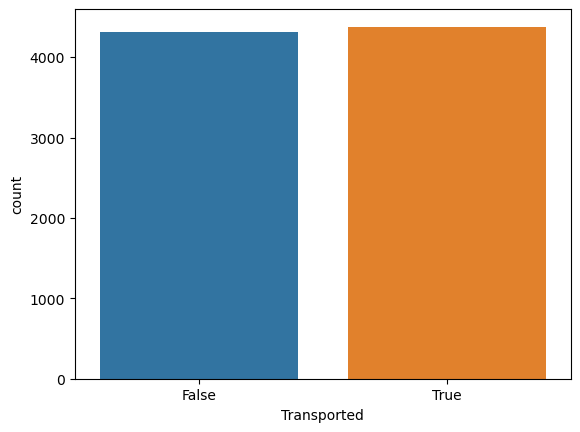

In [6]:
#get an idea of balance 

sns.countplot(x=train['Transported'])
plt.show()

near 50/50 split so no need to reblance dataset

In [7]:
#let's make copies of datasets just in case

train_copy = train.copy()
test_copy = test.copy()

In [8]:
#making new columns before a little EDA to get better understanding

train_copy['GroupId'] = train_copy['PassengerId'].apply(lambda x  : int(str(x).split('_')[0]))
train_copy['Deck'] = train_copy['Cabin'].apply(lambda x : str(x).split('/')[0] if len(str(x).split('/')) > 1 else np.nan)
train_copy['Room'] = train_copy['Cabin'].apply(lambda x : str(x).split('/')[1] if len(str(x).split('/')) > 1 else np.nan)
train_copy['Side'] = train_copy['Cabin'].apply(lambda x : str(x).split('/')[2] if len(str(x).split('/')) > 1 else np.nan)

train_copy.head(17)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,GroupId,Deck,Room,Side
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,1,B,0,P
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,2,F,0,S
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,3,A,0,S
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,3,A,0,S
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,4,F,1,S
5,0005_01,Earth,False,F/0/P,PSO J318.5-22,44.0,False,0.0,483.0,0.0,291.0,0.0,Sandie Hinetthews,True,5,F,0,P
6,0006_01,Earth,False,F/2/S,TRAPPIST-1e,26.0,False,42.0,1539.0,3.0,0.0,0.0,Billex Jacostaffey,True,6,F,2,S
7,0006_02,Earth,True,G/0/S,TRAPPIST-1e,28.0,False,0.0,0.0,0.0,0.0,NaN,Candra Jacostaffey,True,6,G,0,S
8,0007_01,Earth,False,F/3/S,TRAPPIST-1e,35.0,False,0.0,785.0,17.0,216.0,0.0,Andona Beston,True,7,F,3,S
9,0008_01,Europa,True,B/1/P,55 Cancri e,14.0,False,0.0,0.0,0.0,0.0,0.0,Erraiam Flatic,True,8,B,1,P


In [9]:
#drop split columns

train_copy.drop(['Cabin'], axis=1, inplace=True)

null_dataframe(train_copy)

,null_perc
CryoSleep,2.496261
ShoppingMall,2.392730
VIP,2.335212
HomePlanet,2.312205
Name,2.300702
Room,2.289198
Deck,2.289198
Side,2.289198
VRDeck,2.162660
FoodCourt,2.105142


In [10]:
#describe the dataset 

train_copy.describe(percentiles=[0.25, 0.5, 0.75, 0.9, 0.95, 0.99]).T

,count,mean,std,min,25%,50%,75%,90%,95%,99%,max
Age,8514.0,28.827930,14.489021,0.0,19.0,27.0,38.0,49.0,56.00,65.00,79.0
RoomService,8512.0,224.687617,666.717663,0.0,0.0,0.0,47.0,753.0,1274.25,3096.23,14327.0
FoodCourt,8510.0,458.077203,1611.489240,0.0,0.0,0.0,76.0,1026.0,2748.50,8033.31,29813.0
ShoppingMall,8485.0,173.729169,604.696458,0.0,0.0,0.0,27.0,619.6,927.80,2333.44,23492.0
Spa,8510.0,311.138778,1136.705535,0.0,0.0,0.0,59.0,732.0,1607.10,5390.10,22408.0
VRDeck,8505.0,304.854791,1145.717189,0.0,0.0,0.0,46.0,732.6,1534.20,5646.68,24133.0
GroupId,8693.0,4633.389624,2671.028856,1.0,2319.0,4630.0,6883.0,8344.8,8819.40,9184.08,9280.0


appear to be outliers in the dataset esp in the amounts for premium services onboard

In [11]:
#functions for plotting numeric and categorical variables

#plotting numeric variables

def numeric_graphs(df, num_vars, y_value):
    #drop missing values
    df = df.dropna()
    
    for col in num_vars:
        plt.figure()
        plt.tight_layout()
        plt.figure(figsize=(20,5))

        plt.subplot(1,2,1)
        sns.regplot(x = df[col], y=df[y_value])
        stp = stats.pearsonr(df[col], df[y_value])
        str_title = "r = " + "{0:.2f}".format(stp[0]) + "      " "p = " + "{0:.2f}".format(stp[1])
        plt.gca().set_title(str_title, fontsize=11)
        plt.subplot(1,2,2)
        sns.histplot(df[col], bins=10, kde=True)
        plt.show()

        
#boxplots for categorical vs response
def cat_plots(df, cat_vars, y_value):
    
    df = df.dropna()
    for col in cat_vars:
        plt.figure(figsize=(20, 5))
        plt.subplot(1, 2, 1)
        sns.countplot(x=col, data=df, hue=y_value)
        plt.xticks(rotation=30)
        plt.subplot(1, 2, 2)
        sns.barplot(x=col, y=y_value, data=df, estimator=sum)
        plt.xticks(rotation=30)
        plt.show()

In [12]:
train_copy.columns

Index(['PassengerId', 'HomePlanet', 'CryoSleep', 'Destination', 'Age', 'VIP',
       'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Name',
       'Transported', 'GroupId', 'Deck', 'Room', 'Side'],
      dtype='object')

In [13]:
#numeric features

num_vars = list(train_copy.describe().T.index)

cat_vars = ['HomePlanet', 'CryoSleep', 'Destination','VIP','Deck','Side']

y_value = 'Transported'

<Figure size 640x480 with 0 Axes>

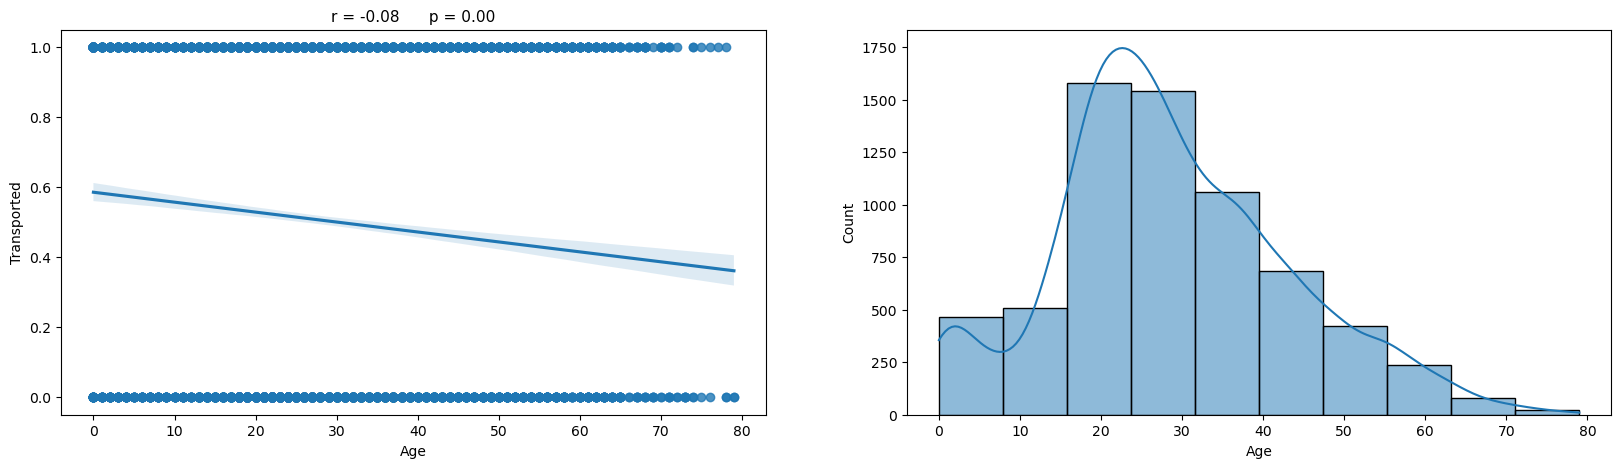

<Figure size 640x480 with 0 Axes>

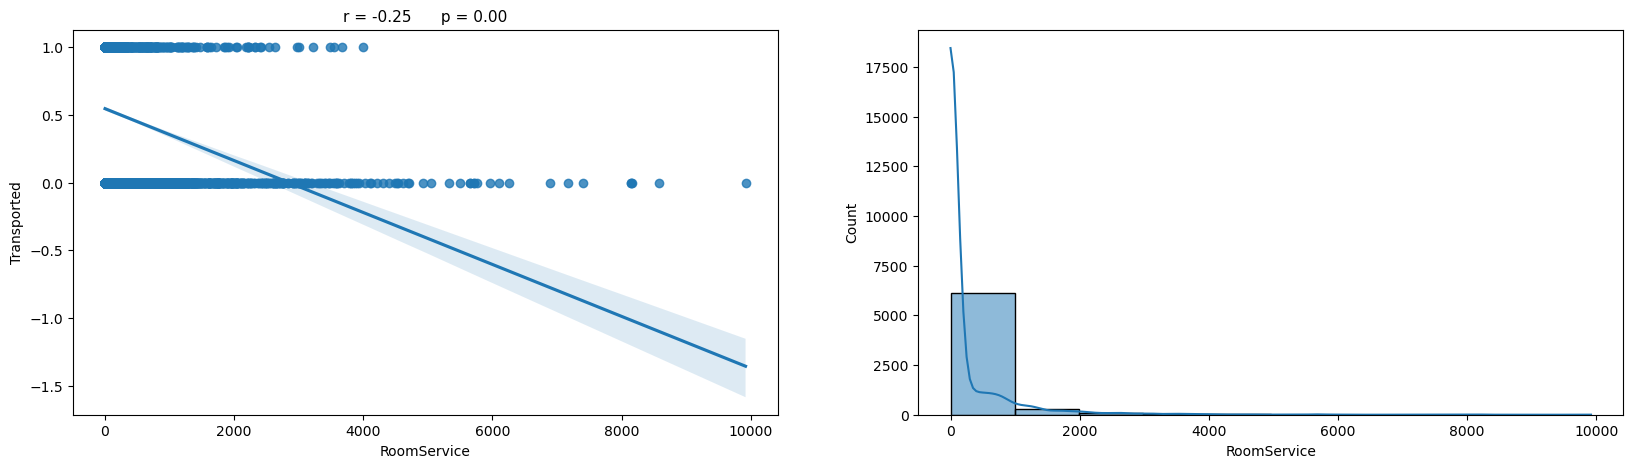

<Figure size 640x480 with 0 Axes>

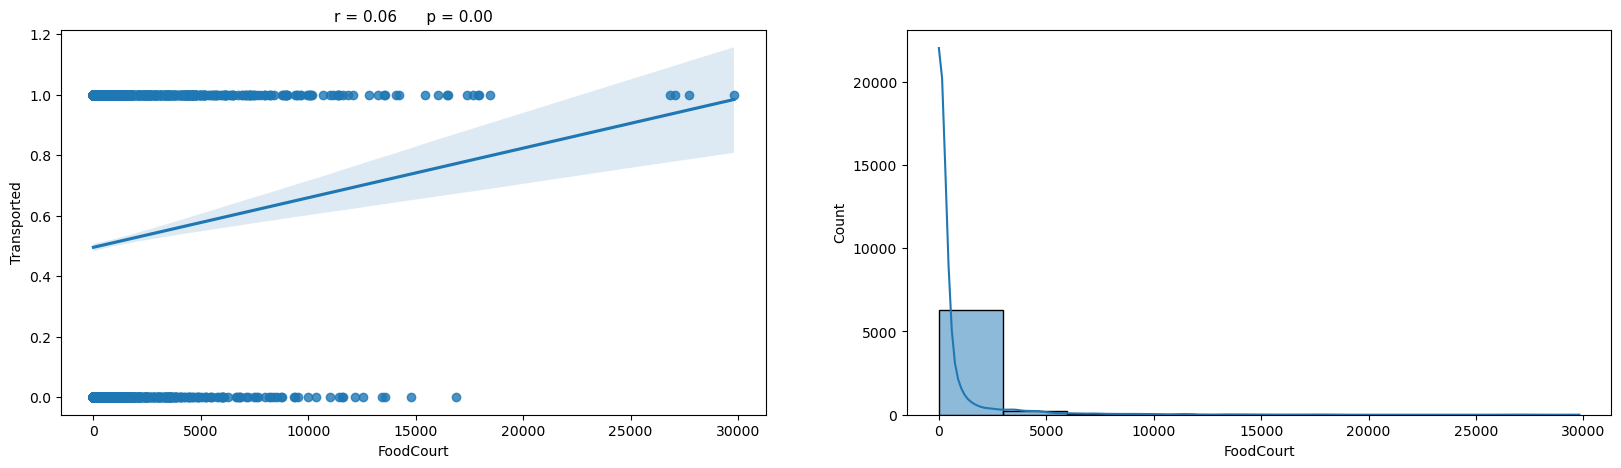

<Figure size 640x480 with 0 Axes>

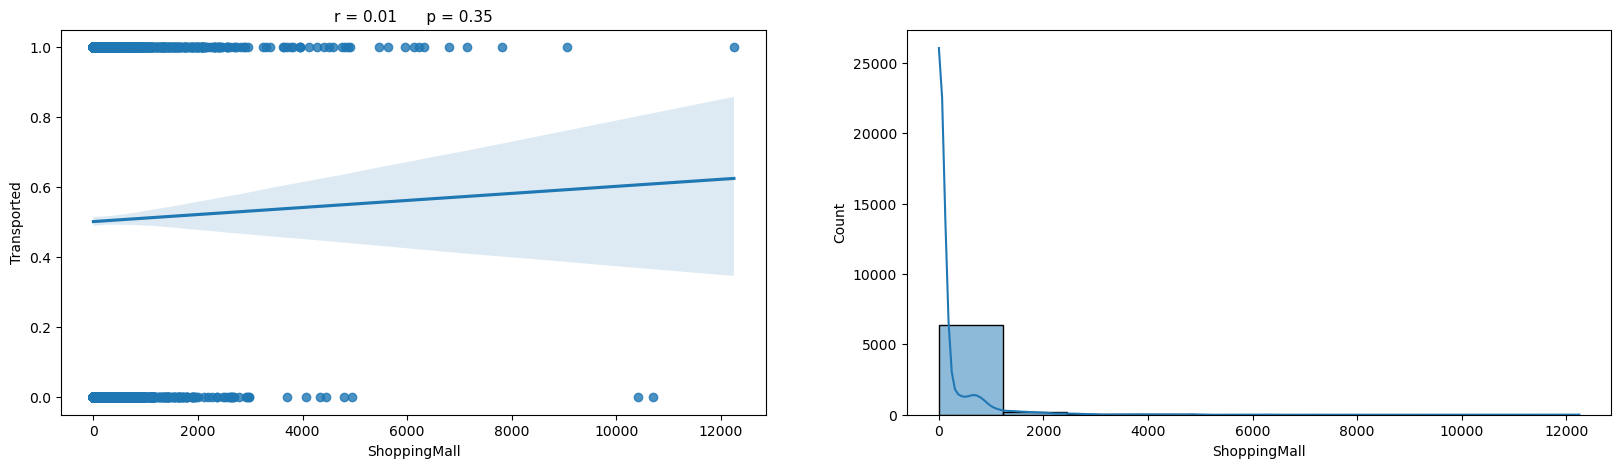

<Figure size 640x480 with 0 Axes>

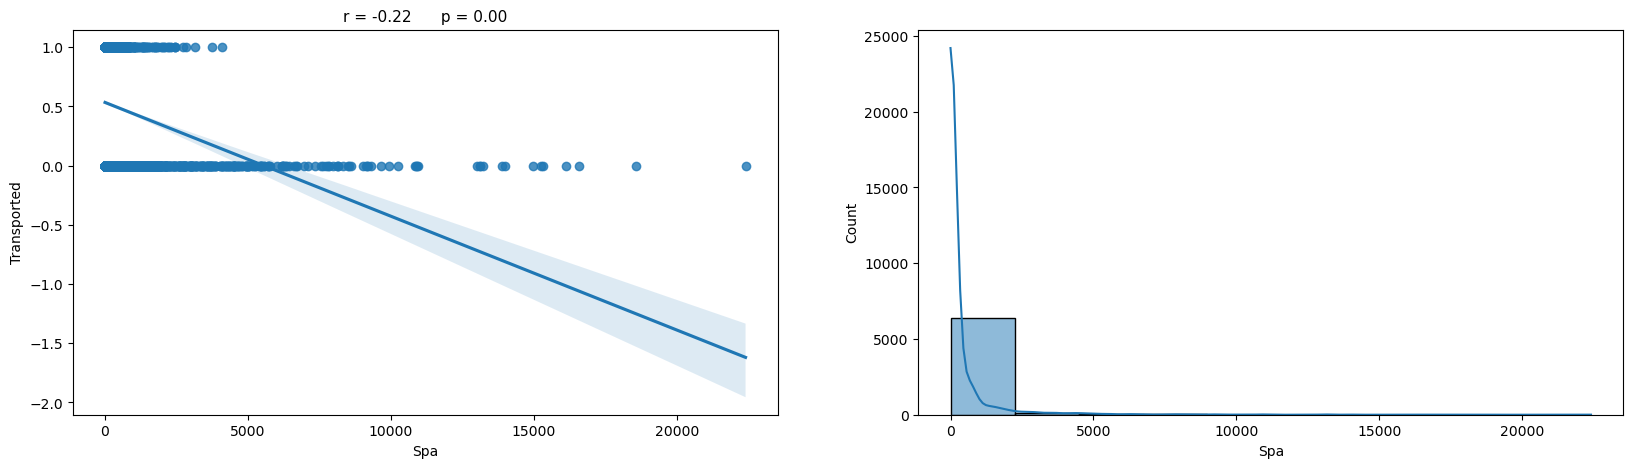

<Figure size 640x480 with 0 Axes>

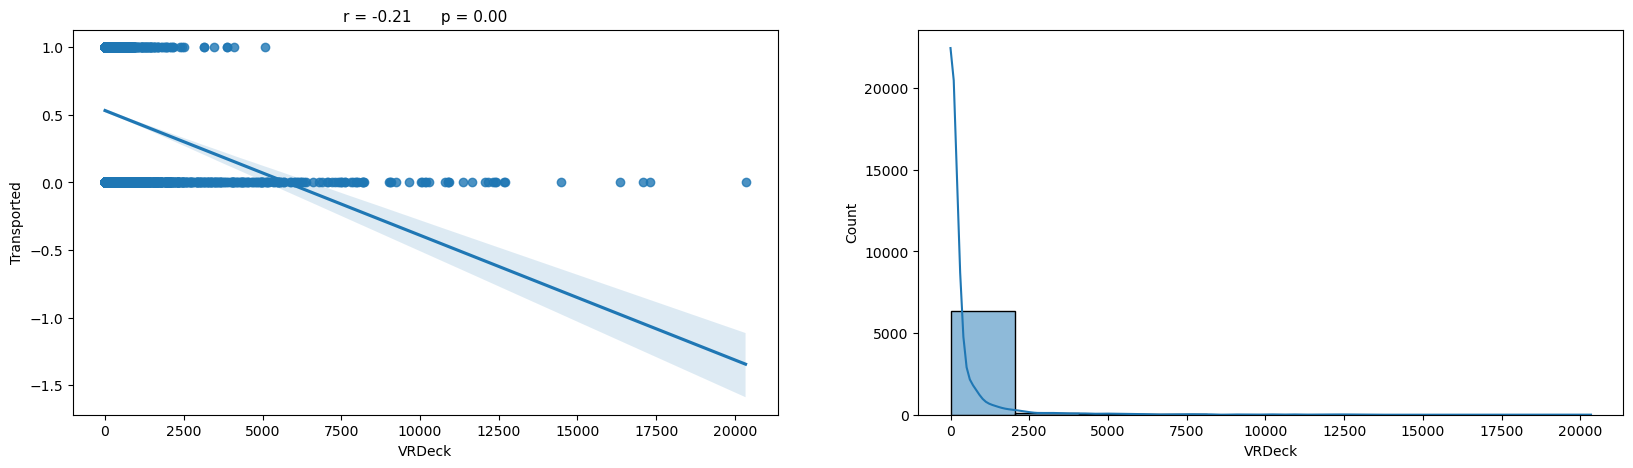

<Figure size 640x480 with 0 Axes>

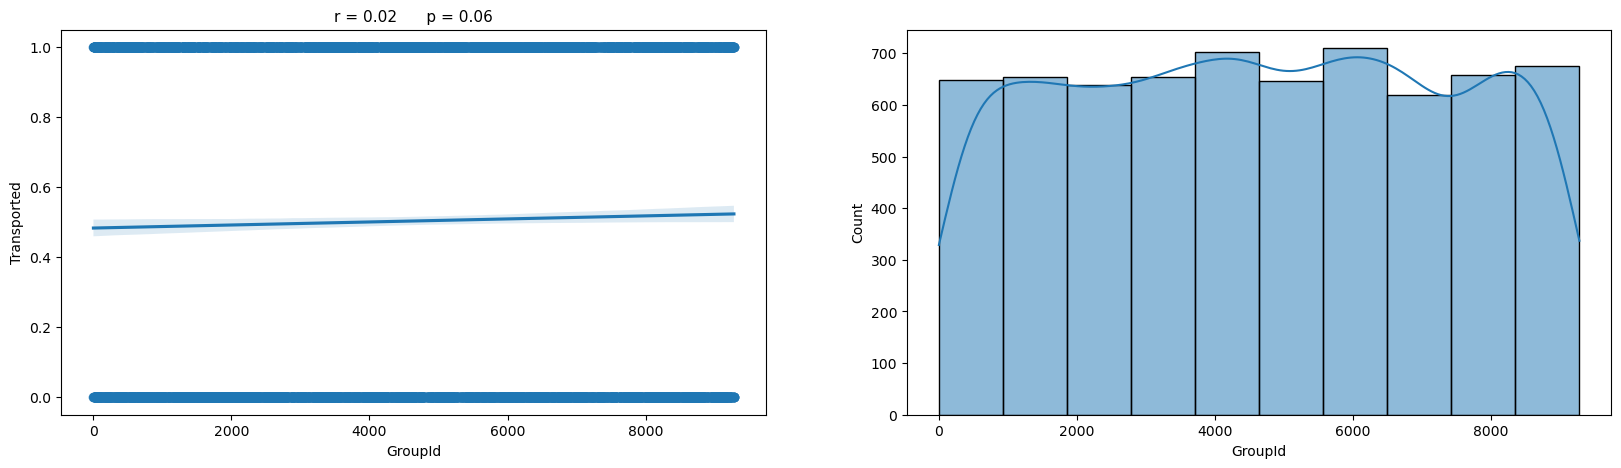

In [14]:
#plot numerics and get a basic idea of distributions

numeric_graphs(train_copy, num_vars, y_value)

foodcourt,vrdeck, spa etc have many outliers here, however it does appear that those with higher spends were less likely to be transported. This seems to be important therefore these outliers may also be important so right off the bat it looks like a basic logistic regression may not work well, also minmaxscaler is not be ideal and a standard scaler may be better to see distributions around the mean

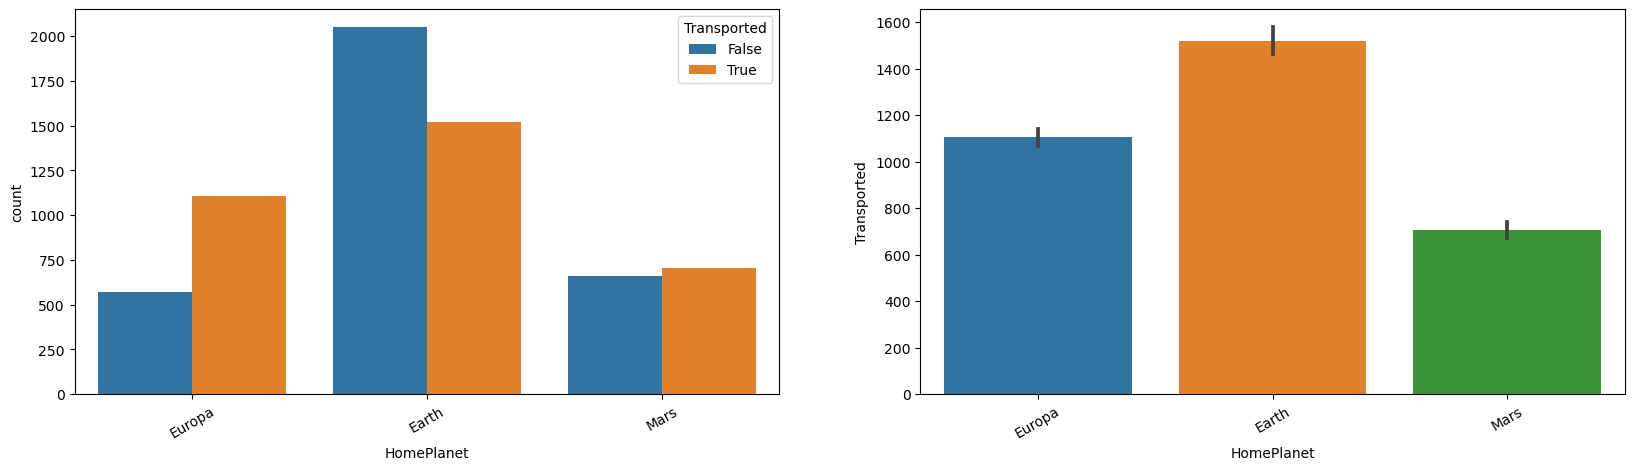

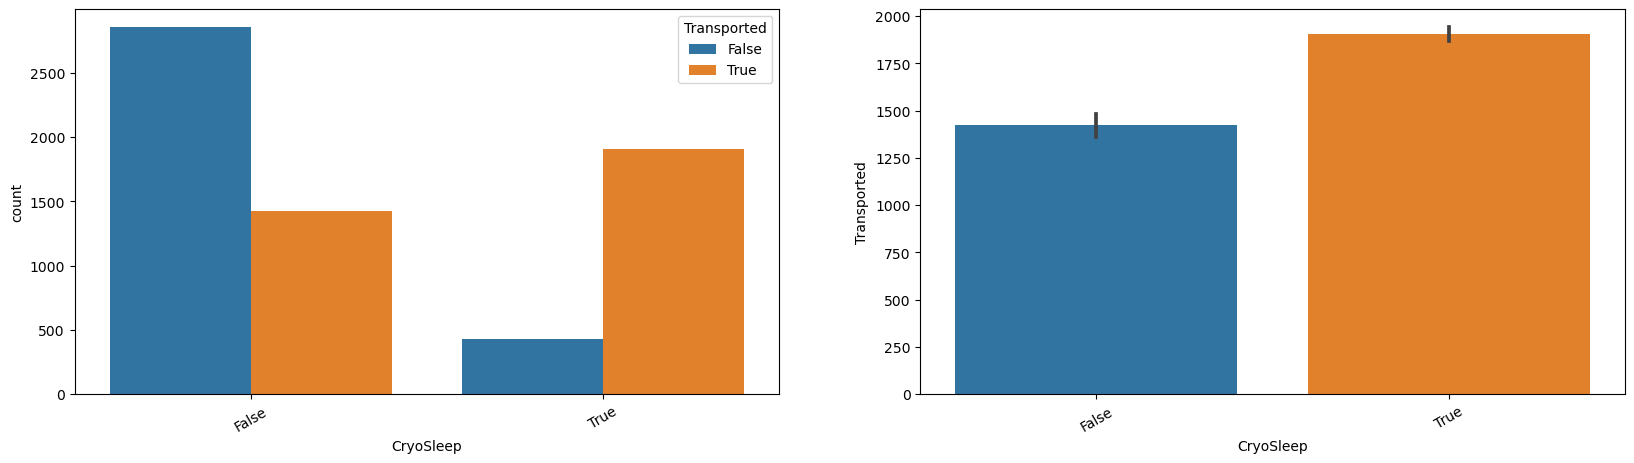

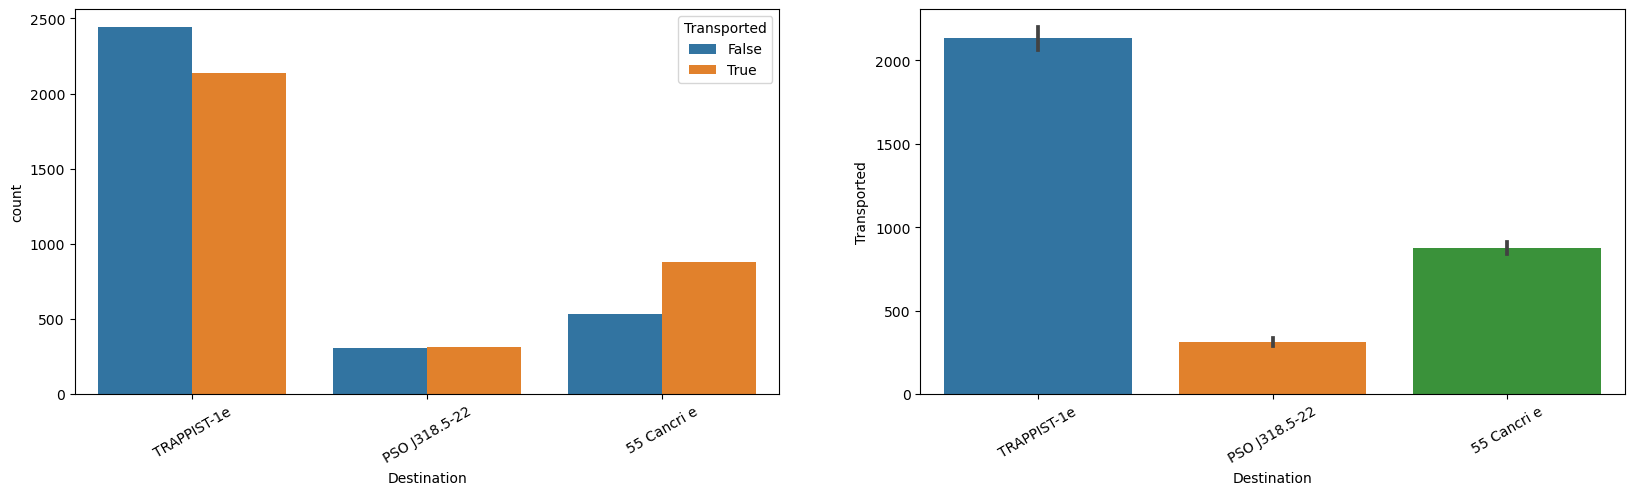

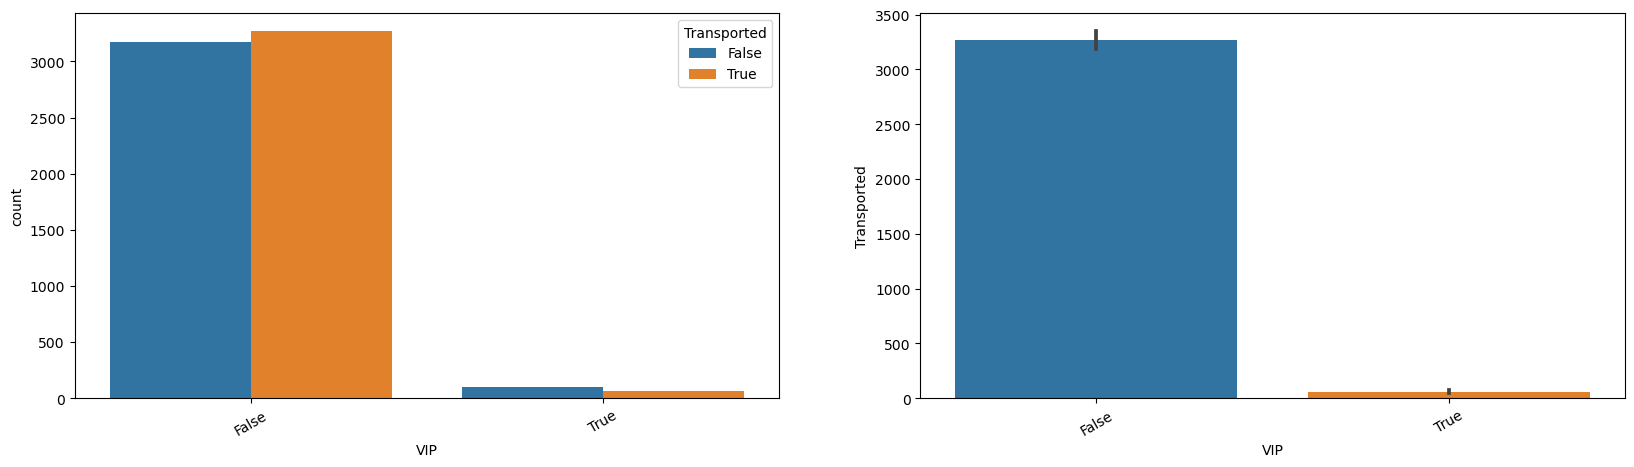

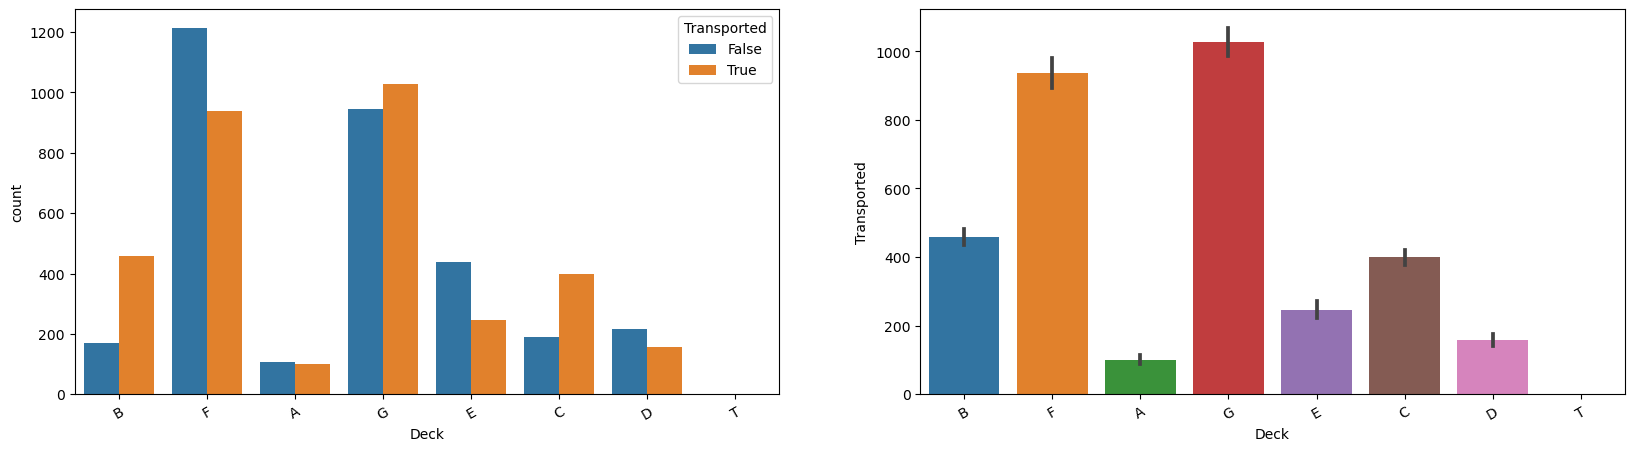

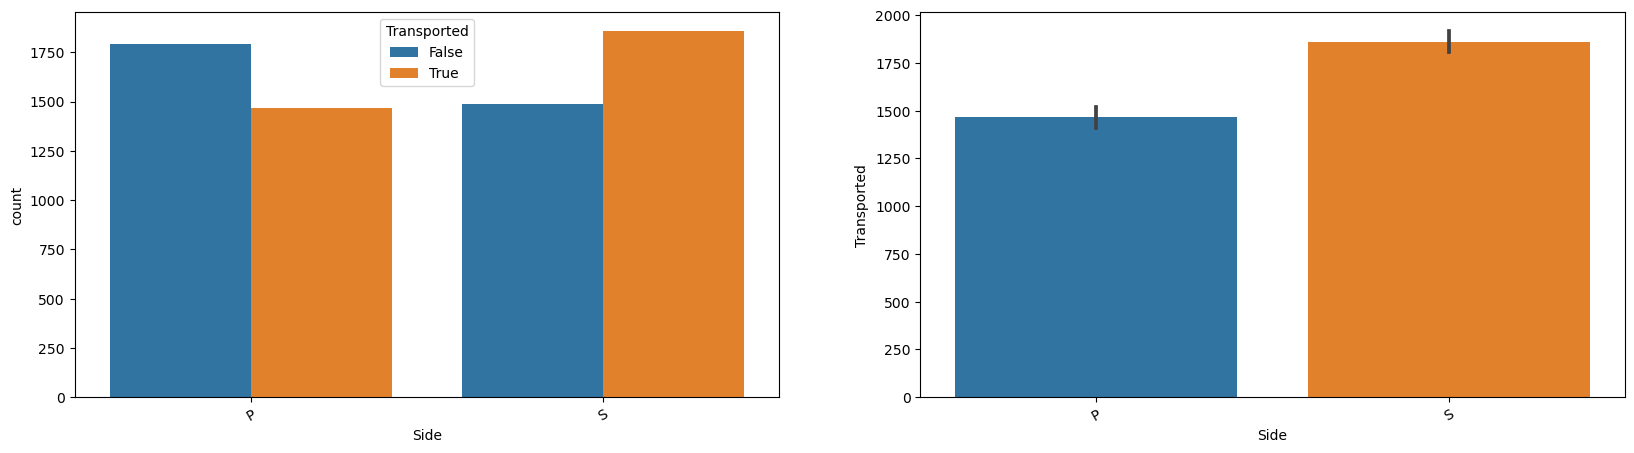

In [15]:
cat_plots(train_copy, cat_vars, y_value)

seems more starboard passengers were transported vs not compared to port. event was on the starboard side of ship?
europa home planet had many transports

### Step 2: Data Preparation

In [16]:
#mapping binary fields

binary_fields = []

for col in train_copy.columns:
    if train_copy[col].nunique() == 2:
        binary_fields.append(col)
        
binary_fields

['CryoSleep', 'VIP', 'Transported', 'Side']

In [17]:
#Side is P or S, will be splitting into dummies so no mapping at the moment

{'True': 1, 'False': 0}

#remove Side from list
binary_fields.remove('Side')

for col in binary_fields:
    train_copy[col] = train_copy[col].astype('str')
    train_copy[col] = train_copy[col].map({'True': 1, 'False': 0, np.nan: np.nan})

train_copy.head()

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,GroupId,Deck,Room,Side
0,0001_01,Europa,0.0,TRAPPIST-1e,39.0,0.0,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,0.0,1,B,0,P
1,0002_01,Earth,0.0,TRAPPIST-1e,24.0,0.0,109.0,9.0,25.0,549.0,44.0,Juanna Vines,1.0,2,F,0,S
2,0003_01,Europa,0.0,TRAPPIST-1e,58.0,1.0,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,0.0,3,A,0,S
3,0003_02,Europa,0.0,TRAPPIST-1e,33.0,0.0,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,0.0,3,A,0,S
4,0004_01,Earth,0.0,TRAPPIST-1e,16.0,0.0,303.0,70.0,151.0,565.0,2.0,Willy Santantines,1.0,4,F,1,S


In [18]:
#side time

train_copy['Side'] = train_copy['Side'].map({'P': 'Port', 'S': 'Starboard', np.nan: np.nan})


In [19]:
#some missing homeplanets and destinations can actually be imputed using groupid.
#some will remain missing esp if there is only one occurence of that id

#make df of groups sans duplicates
groups = train_copy[['GroupId','HomePlanet','Destination']].drop_duplicates().dropna().reset_index(drop=True)

groups.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6750 entries, 0 to 6749
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   GroupId      6750 non-null   int64 
 1   HomePlanet   6750 non-null   object
 2   Destination  6750 non-null   object
dtypes: int64(1), object(2)
memory usage: 158.3+ KB


In [20]:
#dictionary of groupIDs

group_dict = groups.set_index('GroupId').T.to_dict('list')

#map IDs to values in train_copy

for key, values in group_dict.items():
    mask = train_copy['GroupId'].isin([key])
    train_copy.loc[mask & train_copy['HomePlanet'].isnull(), 'HomePlanet'] = values[0]
    train_copy.loc[mask & train_copy['Destination'].isnull(), 'Destination'] = values[1]
    
train_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8693 entries, 0 to 8692
Data columns (total 17 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8581 non-null   object 
 2   CryoSleep     8476 non-null   float64
 3   Destination   8589 non-null   object 
 4   Age           8514 non-null   float64
 5   VIP           8490 non-null   float64
 6   RoomService   8512 non-null   float64
 7   FoodCourt     8510 non-null   float64
 8   ShoppingMall  8485 non-null   float64
 9   Spa           8510 non-null   float64
 10  VRDeck        8505 non-null   float64
 11  Name          8493 non-null   object 
 12  Transported   8693 non-null   float64
 13  GroupId       8693 non-null   int64  
 14  Deck          8494 non-null   object 
 15  Room          8494 non-null   object 
 16  Side          8494 non-null   object 
dtypes: float64(9), int64(1), object(7)
memory usage: 1.2+ MB


the number of nulls decreased for those fields for home planet and destination. next time to impute the mode

In [21]:
#imputing the remainder with mode...note remember to only transform test dataset

locations = ['HomePlanet','Destination']

imp = SimpleImputer(strategy="most_frequent")

for col in locations:
    train_copy[col] = imp.fit_transform(train_copy[col].values.reshape(-1, 1))
    
train_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8693 entries, 0 to 8692
Data columns (total 17 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8693 non-null   object 
 2   CryoSleep     8476 non-null   float64
 3   Destination   8693 non-null   object 
 4   Age           8514 non-null   float64
 5   VIP           8490 non-null   float64
 6   RoomService   8512 non-null   float64
 7   FoodCourt     8510 non-null   float64
 8   ShoppingMall  8485 non-null   float64
 9   Spa           8510 non-null   float64
 10  VRDeck        8505 non-null   float64
 11  Name          8493 non-null   object 
 12  Transported   8693 non-null   float64
 13  GroupId       8693 non-null   int64  
 14  Deck          8494 non-null   object 
 15  Room          8494 non-null   object 
 16  Side          8494 non-null   object 
dtypes: float64(9), int64(1), object(7)
memory usage: 1.2+ MB


In [22]:
#drop name
train_copy.drop(['Name'], axis=1, inplace=True)

In [23]:
train_copy[train_copy['GroupId']==8]

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,GroupId,Deck,Room,Side
9,0008_01,Europa,1.0,55 Cancri e,14.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,8,B,1,Port
10,0008_02,Europa,1.0,TRAPPIST-1e,34.0,0.0,0.0,0.0,NaN,0.0,0.0,1.0,8,B,1,Port
11,0008_03,Europa,0.0,55 Cancri e,45.0,0.0,39.0,7295.0,589.0,110.0,124.0,1.0,8,B,1,Port


Deck, Room and Side, may be best to simply drop those 200 entries as there is no way to know which room and floor the passenger was on

In [24]:
#let's drop and see the number of missing values
train_copy.dropna(subset=['Deck'], inplace=True)
train_copy.reset_index(drop=True, inplace=True)
train_copy.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8494 entries, 0 to 8493
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8494 non-null   object 
 1   HomePlanet    8494 non-null   object 
 2   CryoSleep     8284 non-null   float64
 3   Destination   8494 non-null   object 
 4   Age           8319 non-null   float64
 5   VIP           8297 non-null   float64
 6   RoomService   8317 non-null   float64
 7   FoodCourt     8316 non-null   float64
 8   ShoppingMall  8288 non-null   float64
 9   Spa           8313 non-null   float64
 10  VRDeck        8310 non-null   float64
 11  Transported   8494 non-null   float64
 12  GroupId       8494 non-null   int64  
 13  Deck          8494 non-null   object 
 14  Room          8494 non-null   object 
 15  Side          8494 non-null   object 
dtypes: float64(9), int64(1), object(6)
memory usage: 1.0+ MB


In [25]:
#cat/num-like vars to impute
s_imputes = ['VIP','CryoSleep']

for col in s_imputes:
    train_copy[col] = imp.fit_transform(train_copy[col].values.reshape(-1, 1))
    
train_copy.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8494 entries, 0 to 8493
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8494 non-null   object 
 1   HomePlanet    8494 non-null   object 
 2   CryoSleep     8494 non-null   float64
 3   Destination   8494 non-null   object 
 4   Age           8319 non-null   float64
 5   VIP           8494 non-null   float64
 6   RoomService   8317 non-null   float64
 7   FoodCourt     8316 non-null   float64
 8   ShoppingMall  8288 non-null   float64
 9   Spa           8313 non-null   float64
 10  VRDeck        8310 non-null   float64
 11  Transported   8494 non-null   float64
 12  GroupId       8494 non-null   int64  
 13  Deck          8494 non-null   object 
 14  Room          8494 non-null   object 
 15  Side          8494 non-null   object 
dtypes: float64(9), int64(1), object(6)
memory usage: 1.0+ MB


In [26]:
#imputation of nummeric fields

imp_cols = ['Age','RoomService','FoodCourt','ShoppingMall', 'Spa','VRDeck']

iterative_imputer = IterativeImputer(estimator=RandomForestRegressor(), random_state=seed)

train_copy[imp_cols] = iterative_imputer.fit_transform(train_copy[imp_cols])

train_copy.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8494 entries, 0 to 8493
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8494 non-null   object 
 1   HomePlanet    8494 non-null   object 
 2   CryoSleep     8494 non-null   float64
 3   Destination   8494 non-null   object 
 4   Age           8494 non-null   float64
 5   VIP           8494 non-null   float64
 6   RoomService   8494 non-null   float64
 7   FoodCourt     8494 non-null   float64
 8   ShoppingMall  8494 non-null   float64
 9   Spa           8494 non-null   float64
 10  VRDeck        8494 non-null   float64
 11  Transported   8494 non-null   float64
 12  GroupId       8494 non-null   int64  
 13  Deck          8494 non-null   object 
 14  Room          8494 non-null   object 
 15  Side          8494 non-null   object 
dtypes: float64(9), int64(1), object(6)
memory usage: 1.0+ MB


In [27]:
train_copy.describe(percentiles=[0.25,0.5,0.75,0.9,0.95,0.99]).T

,count,mean,std,min,25%,50%,75%,90%,95%,99%,max
CryoSleep,8494.0,0.347657,0.476255,0.0,0.0,0.0,1.000000,1.000,1.00,1.00,1.0
Age,8494.0,28.812718,14.358164,0.0,20.0,27.0,38.000000,49.000,55.00,65.00,79.0
VIP,8494.0,0.022722,0.149024,0.0,0.0,0.0,0.000000,0.000,0.00,1.00,1.0
RoomService,8494.0,222.873650,636.743395,0.0,0.0,0.0,59.000000,755.700,1268.35,3011.40,9920.0
FoodCourt,8494.0,458.102756,1603.619187,0.0,0.0,0.0,84.750000,1049.000,2677.40,7992.28,29813.0
ShoppingMall,8494.0,174.489547,602.774067,0.0,0.0,0.0,32.910933,618.000,927.00,2316.98,23492.0
Spa,8494.0,308.335062,1110.273714,0.0,0.0,0.0,71.000000,740.833,1606.70,5248.14,22408.0
VRDeck,8494.0,306.577906,1139.968721,0.0,0.0,0.0,54.000000,745.400,1545.05,5617.31,24133.0
Transported,8494.0,0.503650,0.500016,0.0,0.0,1.0,1.000000,1.000,1.00,1.00,1.0
GroupId,8494.0,4644.420768,2668.389652,1.0,2347.0,4643.5,6891.750000,8354.000,8825.35,9185.07,9280.0


In [28]:
#let's visualise again 


cat_vars = ['HomePlanet', 'Destination','VIP','Deck','Side']

num_vars = ['CryoSleep','Age','RoomService','FoodCourt','ShoppingMall','Spa','VRDeck','GroupId']


<Figure size 640x480 with 0 Axes>

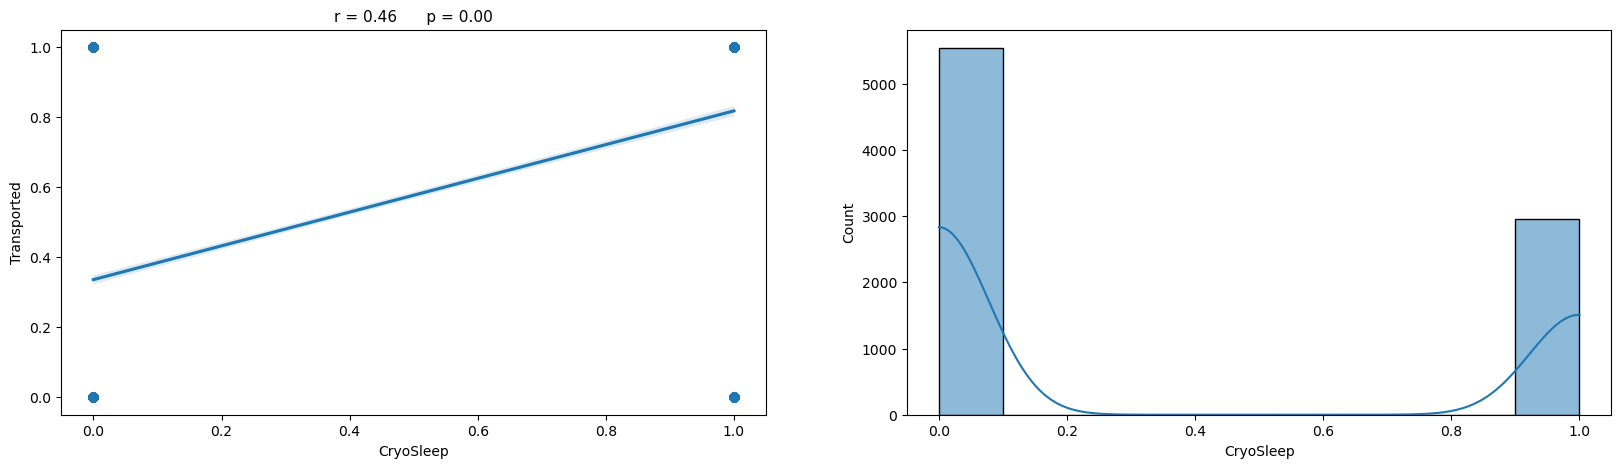

<Figure size 640x480 with 0 Axes>

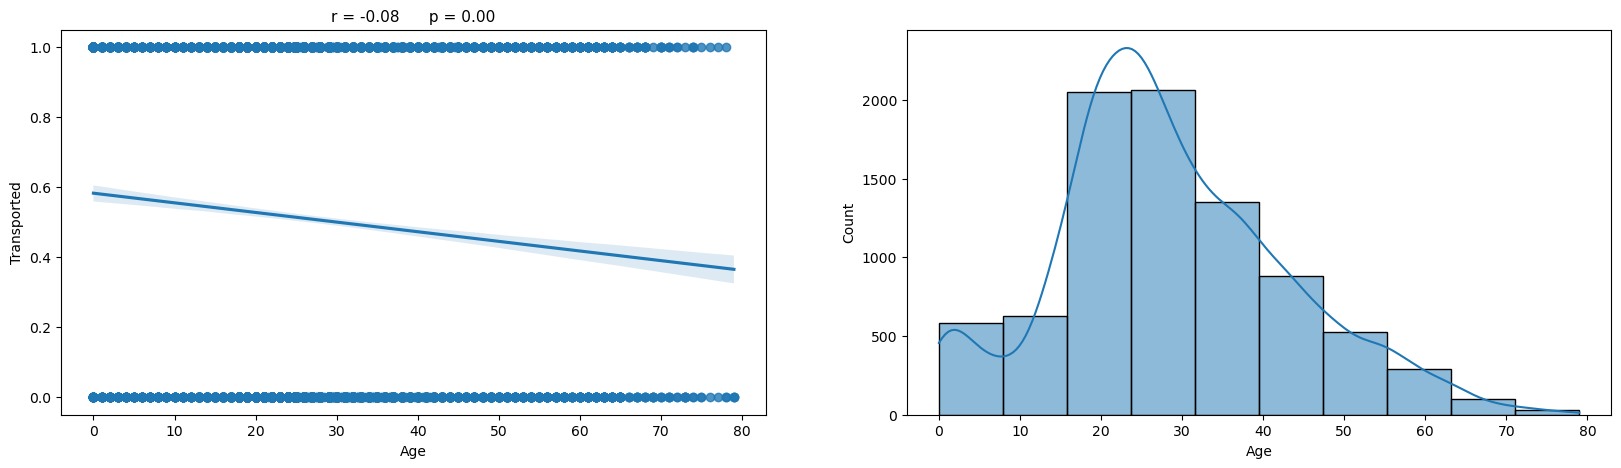

<Figure size 640x480 with 0 Axes>

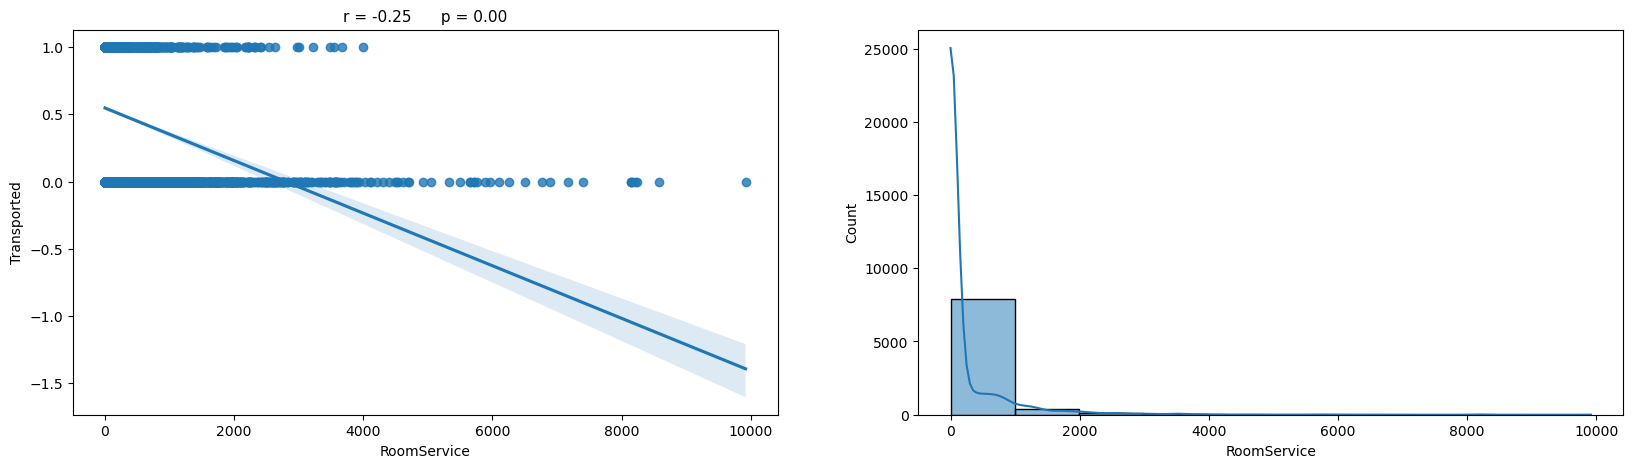

<Figure size 640x480 with 0 Axes>

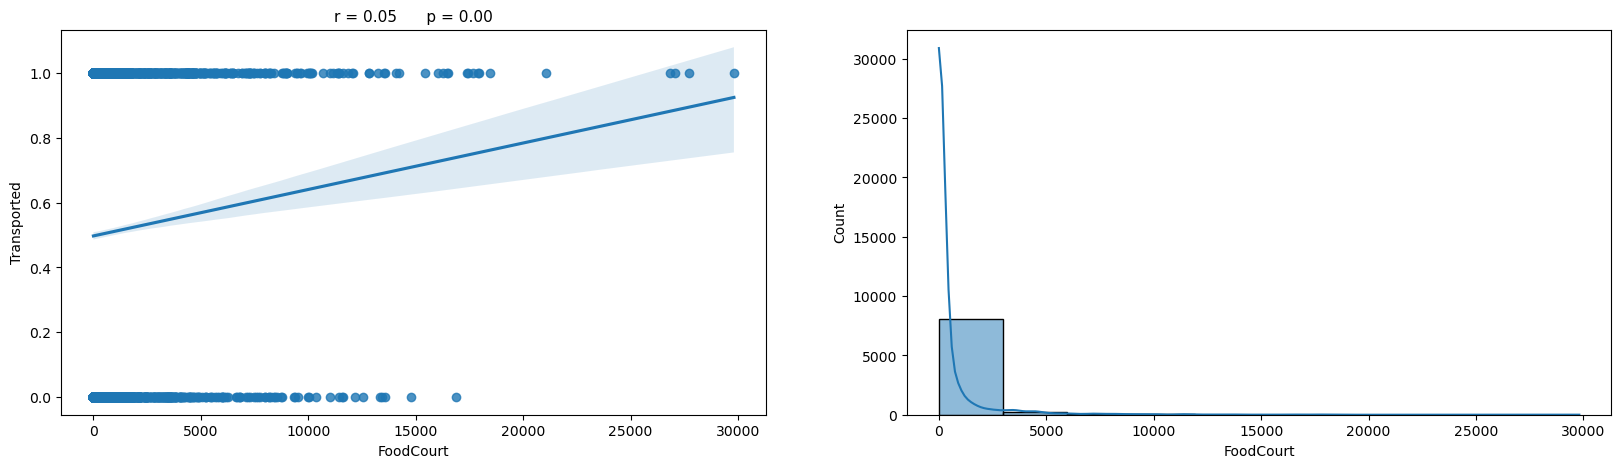

<Figure size 640x480 with 0 Axes>

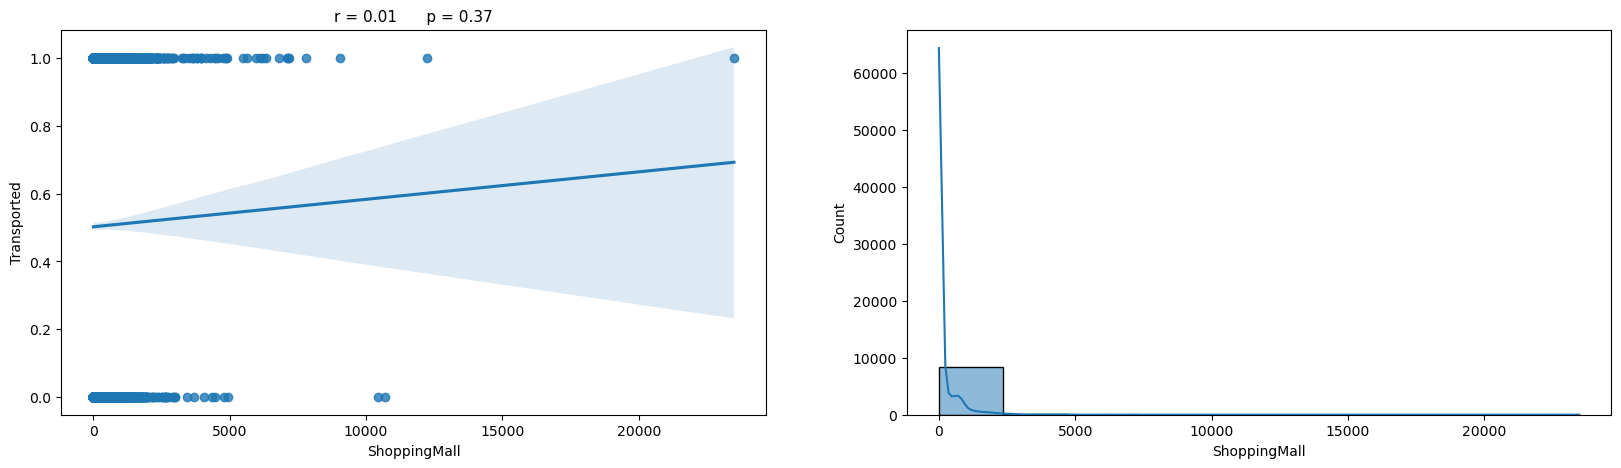

<Figure size 640x480 with 0 Axes>

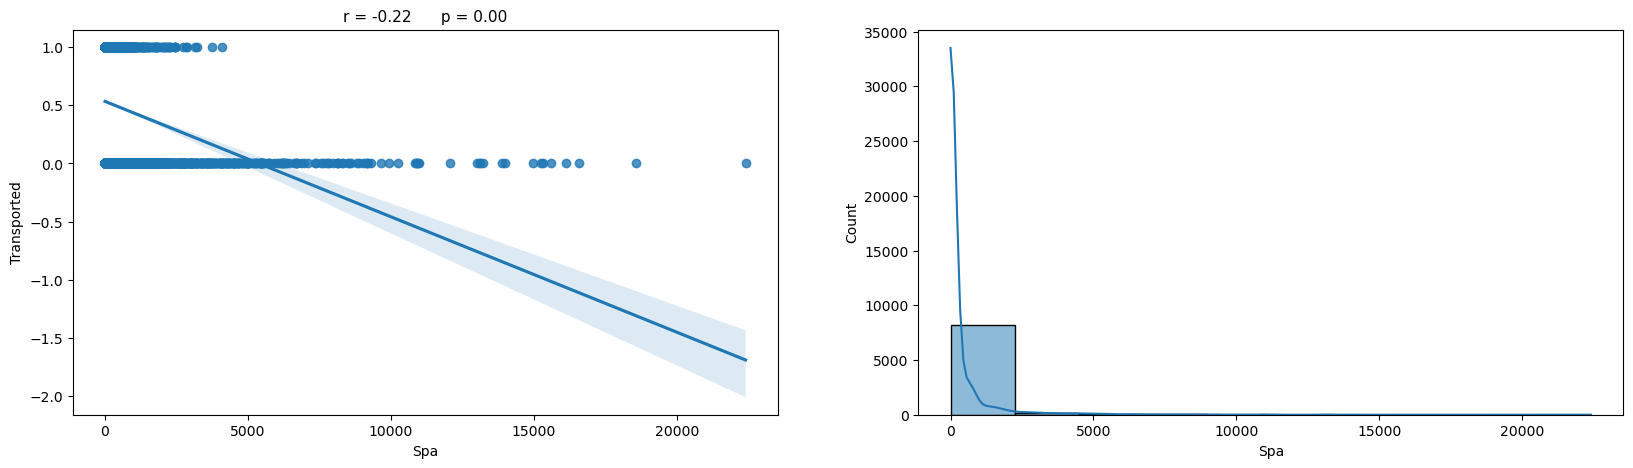

<Figure size 640x480 with 0 Axes>

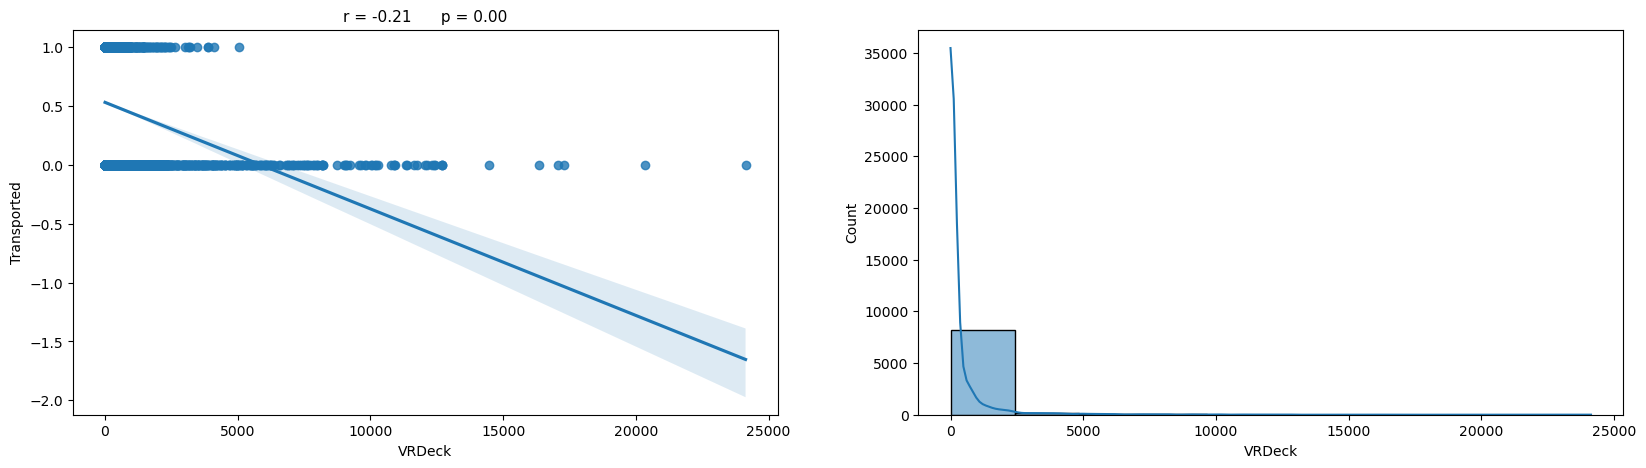

<Figure size 640x480 with 0 Axes>

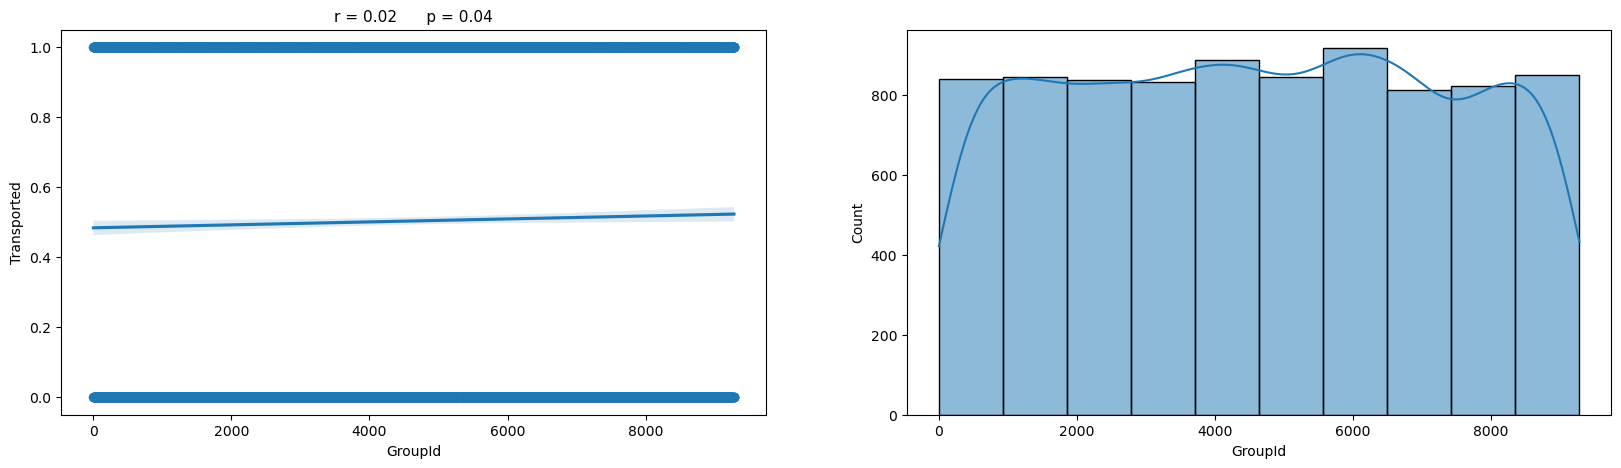

In [29]:
numeric_graphs(train_copy, num_vars, y_value)

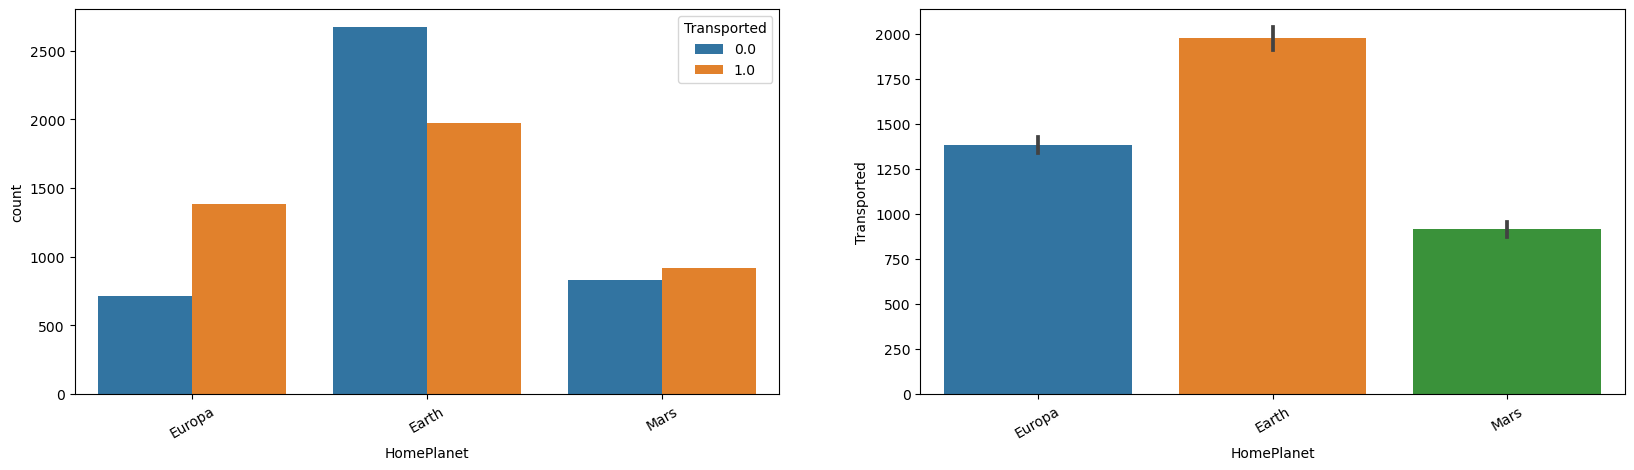

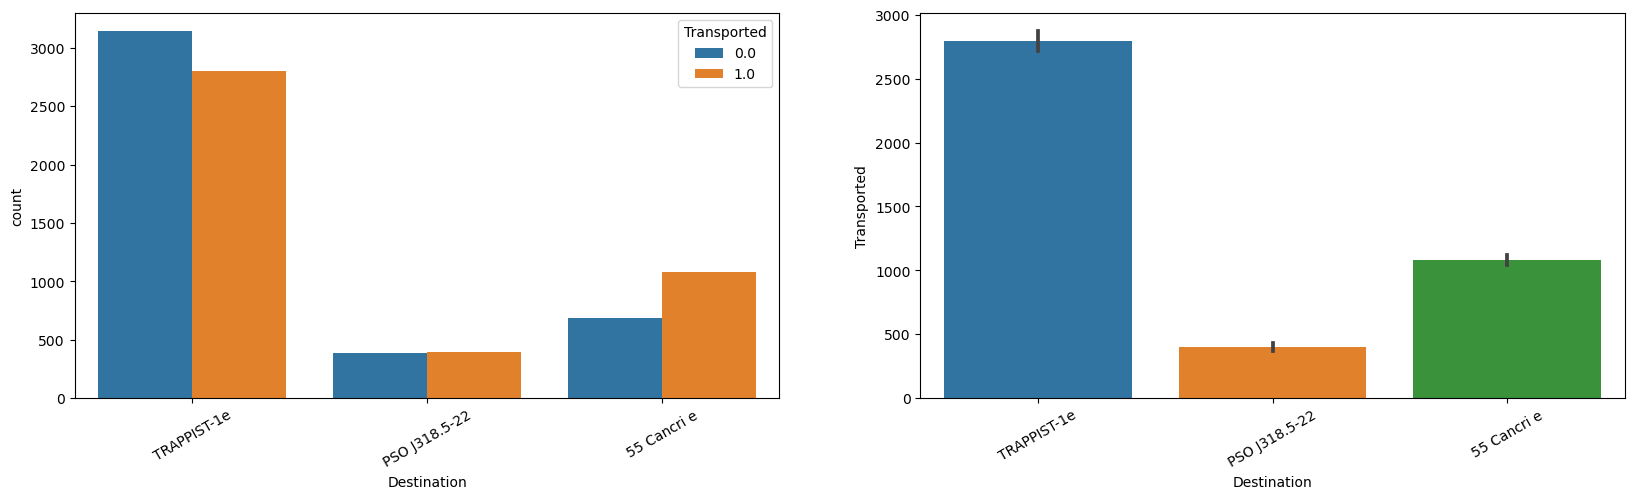

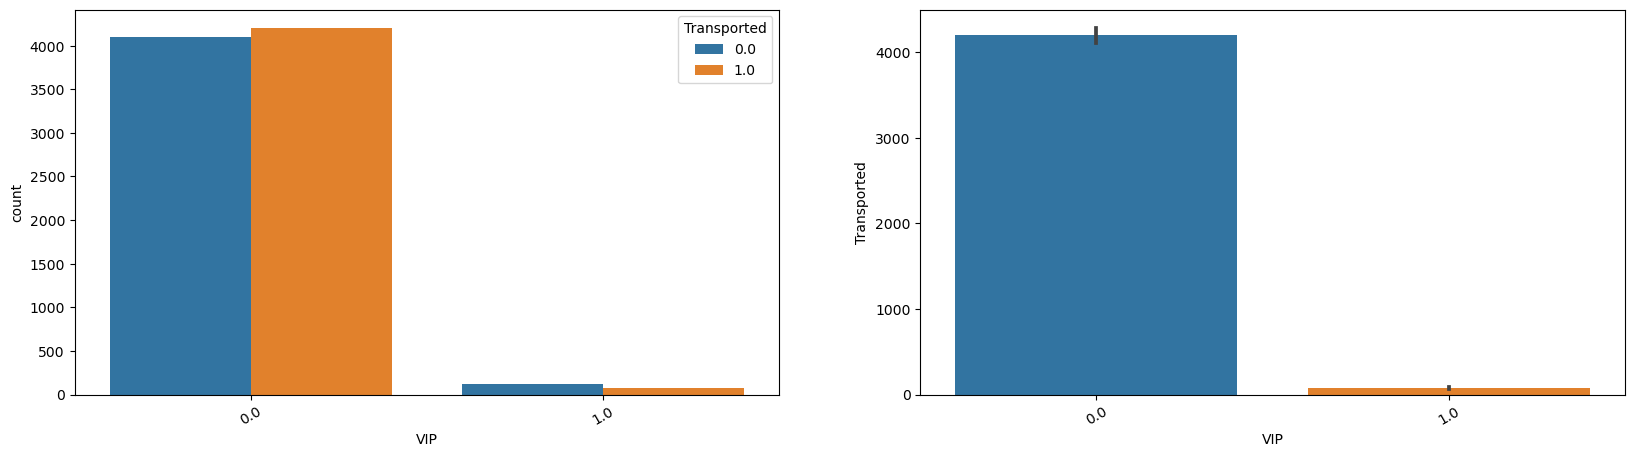

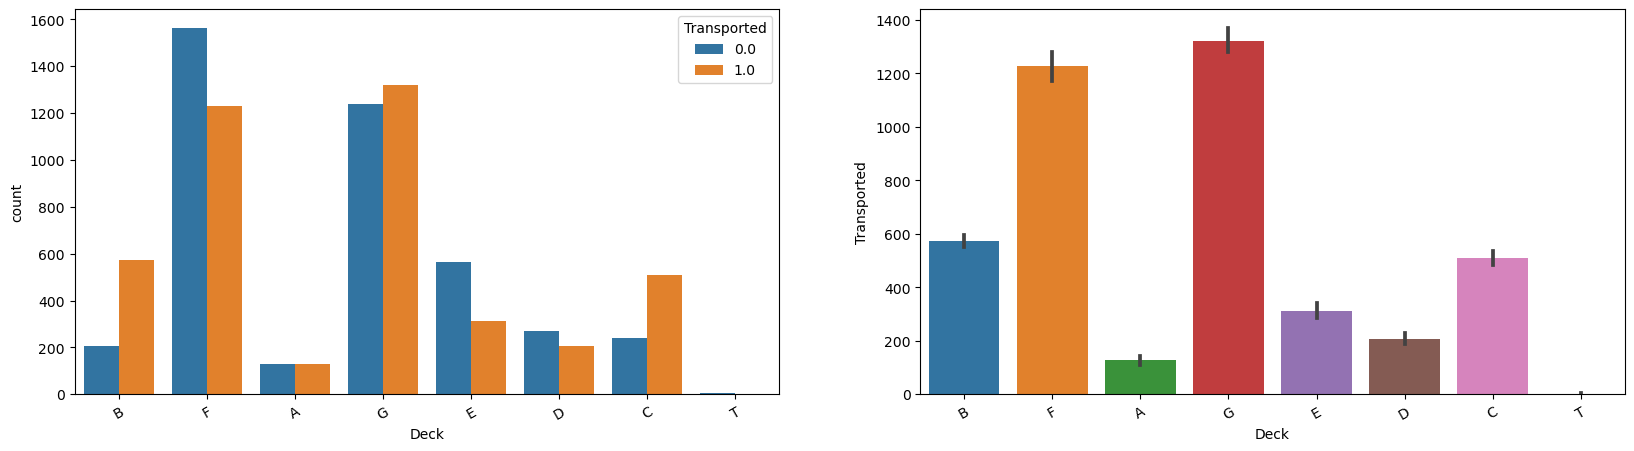

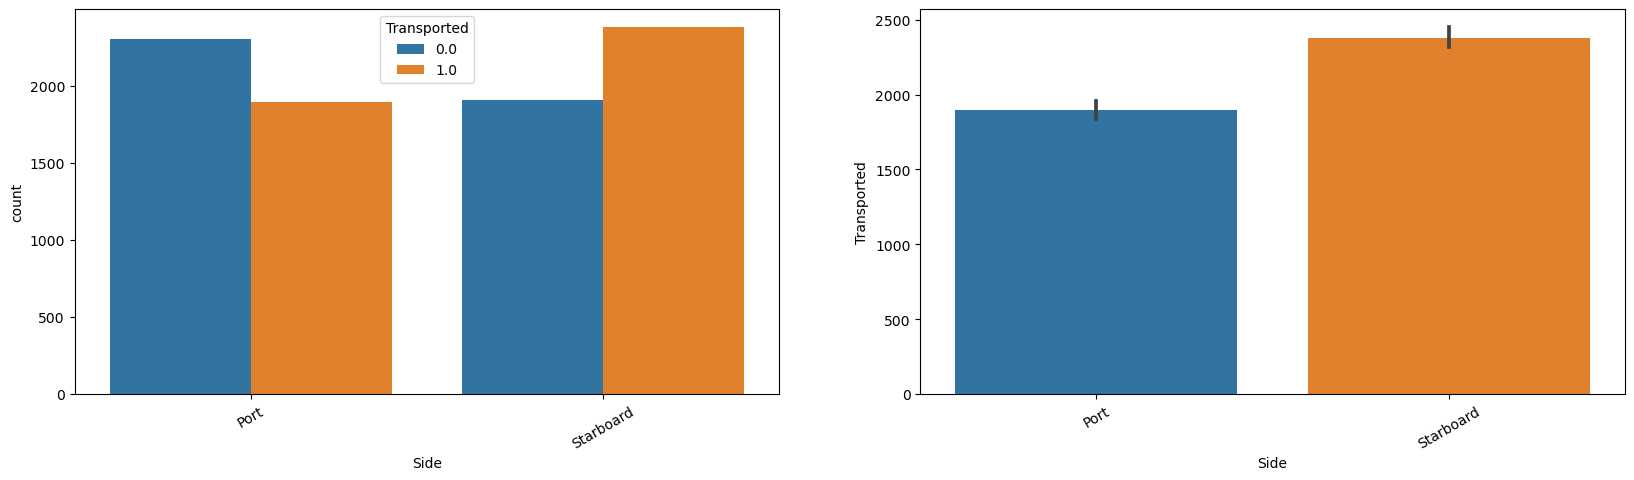

In [30]:
cat_plots(train_copy, cat_vars, y_value)

After imputation, the distributions remain relatively similar, will check the final distribution of the target then move onto further data prep and then test data prep

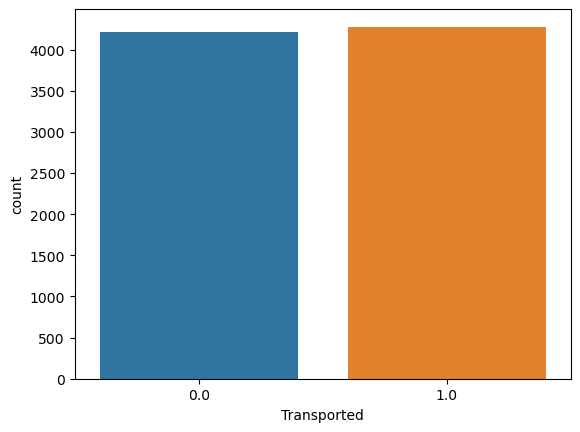

In [31]:
sns.countplot(x=train_copy['Transported'])
plt.show()

still about 50/50. perfect

##### Encoding and scaling features

In [32]:
#VIP, Transported, Cryosleep are floats for some reason. forgot to change them earlier. 

train_copy['VIP'] = train_copy['VIP'].astype(int)
train_copy['Transported'] = train_copy['Transported'].astype(int)
train_copy['CryoSleep'] = train_copy['CryoSleep'].astype(int)


#dropping room and passengerid

train_copy.drop(['PassengerId','Room'], axis= 1, inplace=True)

#Map Side

side = {'Port': 1, 'Starboard': 0}

train_copy['Side'] = train_copy['Side'].map(side)
train_copy['Side'] =  train_copy['Side'].astype(int)



#Deck needs encoding
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1, encoded_missing_value=np.nan)

train_copy['Deck'] = encoder.fit_transform(train_copy[['Deck']])


#make dummies for destination and homeplanet

for col in locations:
    train_copy[col] = train_copy[col].astype(str).apply(lambda x : x.replace(x, col + '-' + x))
    dummy = pd.get_dummies(train_copy[col], drop_first=True)
    train_copy = pd.concat([train_copy, dummy], axis=1)
    train_copy.drop([col], axis=1, inplace=True)


train_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8494 entries, 0 to 8493
Data columns (total 16 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   CryoSleep                  8494 non-null   int32  
 1   Age                        8494 non-null   float64
 2   VIP                        8494 non-null   int32  
 3   RoomService                8494 non-null   float64
 4   FoodCourt                  8494 non-null   float64
 5   ShoppingMall               8494 non-null   float64
 6   Spa                        8494 non-null   float64
 7   VRDeck                     8494 non-null   float64
 8   Transported                8494 non-null   int32  
 9   GroupId                    8494 non-null   int64  
 10  Deck                       8494 non-null   float64
 11  Side                       8494 non-null   int32  
 12  HomePlanet-Europa          8494 non-null   uint8  
 13  HomePlanet-Mars            8494 non-null   uint8

In [33]:
train_copy.head()

,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,GroupId,Deck,Side,HomePlanet-Europa,HomePlanet-Mars,Destination-PSO J318.5-22,Destination-TRAPPIST-1e
0,0,39.0,0,0.0,0.0,0.0,0.0,0.0,0,1,1.0,1,1,0,0,1
1,0,24.0,0,109.0,9.0,25.0,549.0,44.0,1,2,5.0,0,0,0,0,1
2,0,58.0,1,43.0,3576.0,0.0,6715.0,49.0,0,3,0.0,0,1,0,0,1
3,0,33.0,0,0.0,1283.0,371.0,3329.0,193.0,0,3,0.0,0,1,0,0,1
4,0,16.0,0,303.0,70.0,151.0,565.0,2.0,1,4,5.0,0,0,0,0,1


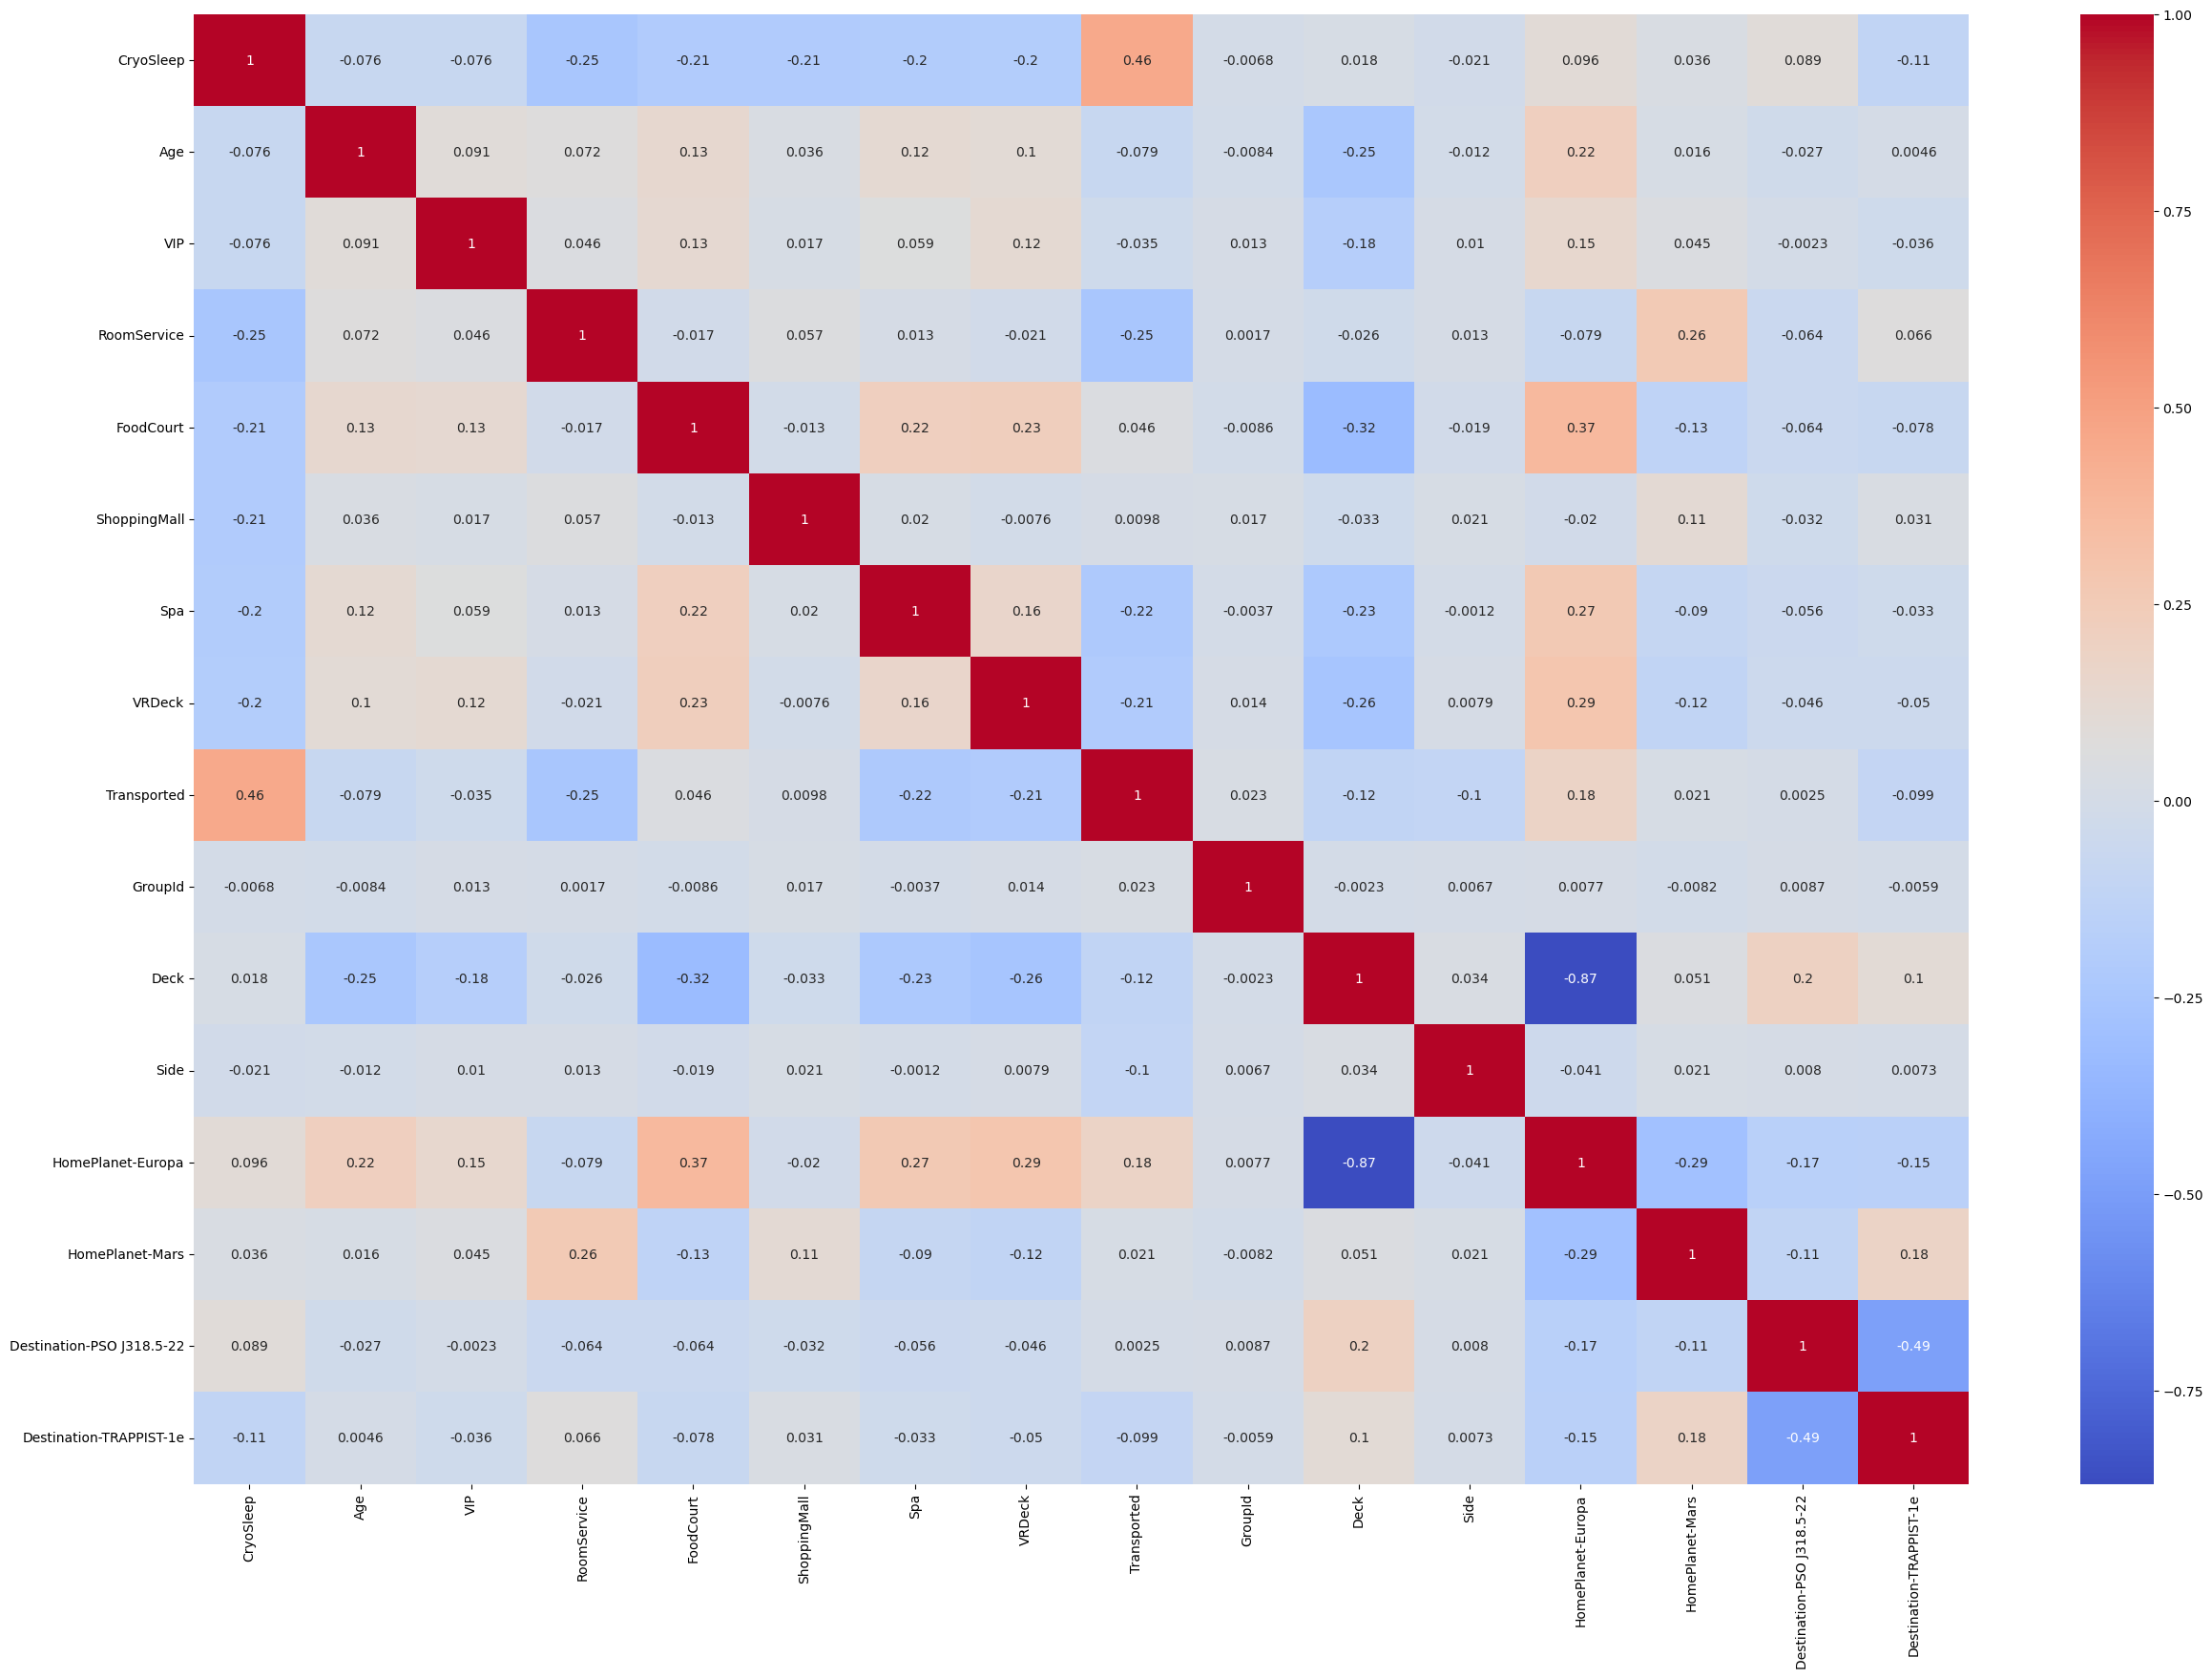

In [34]:
# figure size
plt.figure(figsize=(30,20))

#heatmap once more to confirm
sns.heatmap(train_copy.corr(), annot=True, cmap='coolwarm')
plt.show()

Interesting, deck and europa are a strong linear correlation.
overall there seems to be little in the way of linear relationships between variables. So for our linear models, multicolinearity may be a small issue here

Will move onto scaling. groupid, need to get a count of the unique values there. honestly may not be needed if it is almost unique to everyone 

In [35]:
#scaling

train_copy['GroupId'].nunique()


6118

6118 unique groups but 8494 records. some 2000 entries share a group Id. perhaps it is best to leave it for now 

In [36]:
#scaling

features = ['Age','RoomService','FoodCourt','ShoppingMall','Spa','VRDeck', 'GroupId']

scaler = MinMaxScaler()

#some models need scaled data, others dont
train_copy_scaled = train_copy.copy()
train_copy_scaled[features] = scaler.fit_transform(train_copy_scaled[features])

train_copy_scaled.describe(percentiles=[0.1, 0.25,0.5, 0.75, 0.9,0.95, 0.99]).T

,count,mean,std,min,10%,25%,50%,75%,90%,95%,99%,max
CryoSleep,8494.0,0.347657,0.476255,0.0,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.0
Age,8494.0,0.364718,0.181749,0.0,0.164557,0.253165,0.341772,0.481013,0.620253,0.696203,0.822785,1.0
VIP,8494.0,0.022722,0.149024,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.0
RoomService,8494.0,0.022467,0.064188,0.0,0.000000,0.000000,0.000000,0.005948,0.076179,0.127858,0.303569,1.0
FoodCourt,8494.0,0.015366,0.053789,0.0,0.000000,0.000000,0.000000,0.002843,0.035186,0.089806,0.268080,1.0
ShoppingMall,8494.0,0.007428,0.025659,0.0,0.000000,0.000000,0.000000,0.001401,0.026307,0.039460,0.098628,1.0
Spa,8494.0,0.013760,0.049548,0.0,0.000000,0.000000,0.000000,0.003169,0.033061,0.071702,0.234208,1.0
VRDeck,8494.0,0.012704,0.047237,0.0,0.000000,0.000000,0.000000,0.002238,0.030887,0.064022,0.232765,1.0
Transported,8494.0,0.503650,0.500016,0.0,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0
GroupId,8494.0,0.500423,0.287573,0.0,0.101121,0.252829,0.500323,0.742618,0.900205,0.951002,0.989769,1.0


Data prep for training data is complete. time to work on the test dataset then proceed to model building

In [37]:
#create group id deck and side. 
# no need to make room since i will drop it
test_copy['GroupId'] = test_copy['PassengerId'].apply(lambda x  : int(str(x).split('_')[0]))
test_copy['Deck'] = test_copy['Cabin'].apply(lambda x : str(x).split('/')[0] if len(str(x).split('/')) > 1 else np.nan)
test_copy['Side'] = test_copy['Cabin'].apply(lambda x : str(x).split('/')[2] if len(str(x).split('/')) > 1 else np.nan)

#drop cabin and passengerid and name
test_copy.drop(['Cabin','PassengerId', 'Name'], axis=1, inplace = True)

#change encoding for ['CryoSleep', 'VIP', 'Transported']

binary_fields = ['CryoSleep', 'VIP']
binary = {'True': 1, 'False': 0, np.nan: np.nan}

for col in binary_fields:
    test_copy[col] = test_copy[col].astype('str')
    test_copy[col] = test_copy[col].map({'True': 1, 'False': 0, np.nan: np.nan})
    test_copy[col] = pd.to_numeric(test_copy[col], errors='coerce', downcast='integer')

#map Side
side_test = {'P': 1, 'S': 0, np.nan: np.nan}
test_copy['Side'] = test_copy['Side'].map(side_test)
test_copy['Side'] =  pd.to_numeric(test_copy['Side'], errors='coerce', downcast='integer')


#imputing locations
#make df of groups sans duplicates
groups_test = test_copy[['GroupId','HomePlanet','Destination']].drop_duplicates().dropna().reset_index(drop=True)
group_dict = groups_test.set_index('GroupId').T.to_dict('list')

#map IDs to values in train_copy

for key, values in group_dict.items():
    mask = test_copy['GroupId'].isin([key])
    test_copy.loc[mask & test_copy['HomePlanet'].isnull(), 'HomePlanet'] = values[0]
    test_copy.loc[mask & test_copy['Destination'].isnull(), 'Destination'] = values[1]

#imputing the remainder of nans in locations and VIP and cryosleep
cat_imputes = ['VIP','CryoSleep','HomePlanet','Destination']

for col in cat_imputes:
    test_copy[col] = imp.transform(test_copy[col].values.reshape(-1, 1))
    
    
#imputation of nummeric fields

test_copy[imp_cols] = iterative_imputer.transform(test_copy[imp_cols])

#encoding deck
test_copy['Deck'] = encoder.transform(test_copy[['Deck']])


#make dummies for destination and homeplanet

for col in locations:
    test_copy[col] = test_copy[col].astype(str).apply(lambda x : x.replace(x, col + '-' + x))
    dummy = pd.get_dummies(test_copy[col], drop_first=True)
    test_copy = pd.concat([test_copy, dummy], axis=1)
    test_copy.drop([col], axis=1, inplace=True)

    
#make scaled test version

test_copy_scaled = test_copy.copy()
test_copy_scaled[features] = scaler.transform(test_copy_scaled[features])
print(test_copy.info())
print()
print(test_copy_scaled.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4277 entries, 0 to 4276
Data columns (total 17 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   CryoSleep                  4277 non-null   float64
 1   Age                        4277 non-null   float64
 2   VIP                        4277 non-null   float64
 3   RoomService                4277 non-null   float64
 4   FoodCourt                  4277 non-null   float64
 5   ShoppingMall               4277 non-null   float64
 6   Spa                        4277 non-null   float64
 7   VRDeck                     4277 non-null   float64
 8   GroupId                    4277 non-null   int64  
 9   Deck                       4277 non-null   float64
 10  Side                       4177 non-null   float64
 11  HomePlanet-Earth           4277 non-null   uint8  
 12  HomePlanet-Europa          4277 non-null   uint8  
 13  HomePlanet-Mars            4277 non-null   uint8

In [38]:
#splitting to dependent and independent
y_scaled, y_train = train_copy_scaled.pop('Transported'), train_copy.pop('Transported')

X_scaled, X_train = train_copy_scaled, train_copy


#train test splits
#train test split using scaled data
X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(X_scaled, y_scaled, test_size = 0.2, train_size = 0.8 ,random_state = seed)

#train test split using scaled data - models that do not require scaling
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size = 0.2, train_size = 0.8 ,random_state = seed)


In [39]:
#function for running models and comparing accuracy of baseline models

def model_eval(models, X_train, y_train, X_test, y_test):
    for model in models:
        init_model = model
        
        init_model.fit(X_train, y_train)
        
        #make predictions
        y_pred = init_model.predict(X_test)
        
        #print accuracy
        print(f"accuracy of {model} is {accuracy_score(y_true=y_test, y_pred=y_pred)*100}% \n")
        

In [40]:
scaled_models = [LogisticRegression(), KNeighborsClassifier(), SVC()]
model_eval(scaled_models, X_train_scaled, y_train_scaled, X_test_scaled, y_test_scaled)

accuracy of LogisticRegression() is 77.39846968805179% 

accuracy of KNeighborsClassifier() is 73.6904061212478% 

accuracy of SVC() is 74.98528546203649% 



In [41]:
unscaled_models = [xgb.XGBClassifier(), AdaBoostClassifier(), RandomForestClassifier(), GaussianNB(),
                   GradientBoostingClassifier()]

model_eval(unscaled_models,X_train, y_train, X_test, y_test)

accuracy of XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...) is 80.9299587992937% 

accuracy of AdaBoostClassifier() is 80.69452619187759% 

accuracy of RandomForestClassifier() is 81.75397292525015% 

accuracy of GaussianNB() is 70.27663331371396% 

accuracy of GradientBoostingClassifier() is 82

Right off the bat any model that performed worse than Logistic Regression is out. This eliminates all models that are unable to handle missing values, outliers and require scaling. This was expected. Say bye bye to KNN and SVC. 

In the ensembles there is much better performance except for NB which is not an ensemble. I believe I will build 4 models using XGB, GBM, AdaBoost and RandomForest and select the model that performs best on the evaluation metric - accuracy

In [42]:
folds = KFold(n_splits=4, shuffle=True, random_state=seed)

models = {'XGBoost':xgb.XGBClassifier(objective = 'binary:logistic'),
         'AdaBoost': AdaBoostClassifier(),
         'Random Forests': RandomForestClassifier(),
         'GBM':GradientBoostingClassifier()}

params = {'XGBoost' : {'booster':['dart','gbtree'],
                      'learning_rate': [0.01,0.02,0.05,0.1,0.3,0.5],
                       'n_estimators': [100, 200, 500, 750],
                       'min_child_weight': [1, 5, 7, 10],
                       'gamma': [0.1, 0.5, 1, 1.5, 5],
                       'subsample': [0.6, 0.8, 1.0],
                       'colsample_bytree': [0.6, 0.8, 1.0],
                       'max_depth': [3, 4, 5, 10, 12]},
          
          'AdaBoost' : {'n_estimators':[50, 100, 200, 500, 750],
                        'learning_rate': [0.01,0.02,0.05,0.1,0.3,0.5],
                        'algorithm': ['SAMME', 'SAMME.R']},
          
          
          'Random Forests': {'max_depth': [2,3,5,10,20],
                            'min_samples_leaf': [5,10,20,50,100,200],
                            'n_estimators': [50, 100, 200, 300, 500, 800],
                            'max_features' : ['auto', 'sqrt']},
          
          'GBM' : {'n_estimators':[100, 200, 500, 750],
                   'max_features' : ['auto', 'sqrt'],
                   'min_samples_leaf': [5,10,20,50,100,200],
                   'subsample': [0.6, 0.8, 1.0],
                   'learning_rate': [0.01,0.02,0.05,0.1,0.3,0.5]}}




In [43]:
#function for tuning and evals


def model_comparison(models, X_train, y_train, X_test, y_test, folds, params):
    overall_start = datetime.datetime.now()
    print(f"start time {overall_start}")
    for model_name, model in models.items():
        start_time = datetime.datetime.now()
        print(f'Hyperparameter tuning for {model_name} starting at {start_time}')
        
        #hyper tune
        random_tune = RandomizedSearchCV(estimator = model, 
                                         param_distributions = params[model_name],
                                        cv = folds,
                                        scoring='accuracy',
                                        n_iter=100,
                                        verbose=1,
                                        n_jobs=-1,
                                        return_train_score=False)
        
        random_tune.fit(X_train,y_train)
        
        #get the best model
        best_estimator = random_tune.best_estimator_
        
        best_model = best_estimator.fit(X_train)
        
        #make predictions
        y_pred = best_model.predict(X_test)
        
        accuracy = round(accuracy_score(y_true=y_test, y_pred=y_pred)*100, 3)
        
        #time for cv
        end_time = datetime.datetime.now()
        elapsed_time = end_time - start_time
        # Convert elapsed time to hours, minutes, and seconds
        hours = elapsed_time.seconds // 3600
        minutes = (elapsed_time.seconds % 3600) // 60
        seconds = elapsed_time.seconds % 60
        

    
        print(f"Best Params found are {random_tune.best_params_} with a test accuracy of {accuracy}%")
        print(f"time taken for tuning {hours} hours, {minutes} minutes, {seconds} seconds")
        print('='*30)
        
    #how long this function ran in total
    overall_end_time = datetime.datetime.now()
    
    overall_elapsed = overall_end_time - overall_start
    hours = overall_elapsed.seconds // 3600
    minutes = (overall_elapsed.seconds % 3600) // 60
    seconds = overall_elapsed.seconds % 60
    print(f"time taken for tuning {hours} hours, {minutes} minutes, {seconds} seconds")
        
          
        

In [ ]:
model_comparison(models, X_train, y_train, X_test, y_test, folds, params)

start time 2023-05-29 15:03:09.743828
Hyperparameter tuning for XGBoost starting at 2023-05-29 15:03:09.743828
Fitting 4 folds for each of 100 candidates, totalling 400 fits


In [ ]:
notebook_end_time = datetime.datetime.now()

total_run_time = notebook_end_time - notebook_start_time
hours = total_run_time.seconds // 3600
minutes = (total_run_time.seconds % 3600) // 60
seconds = total_run_time.seconds % 60
print(f"time taken for tuning {hours} hours, {minutes} minutes, {seconds} seconds")
